This databooks tries to refine the analysis done in Milestone 3 by exploring alternative approaches.

In [59]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.display import display, HTML

import itertools

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline


df_genres = pd.read_csv('midi_dataframe_genres_flattened.csv', parse_dates=[11], index_col='file_name')

num_games = len(df_genres.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df_genres.groupby('file_name')),
        num_games,
        (df_genres.tgdb_gametitle.notnull().sum())))

df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df_genres.join(df_features, how='inner').groupby('file_name'))))

There is 22179 midi files, from 3243 games, with 34510 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


In [60]:
df_genres['release_year'] = pd.to_datetime(df_genres['tgdb_releasedate']).dt.year

# Research Question

The research question is formally defined as "Is it possible to successfully categorize video game music by video game genre using music features?".

[Add assumptions]

The dataset is composed of 22005 MIDI files containing tracks from video games. The dataset was obtained by cross-referencing two databases: the Video Game Music Archive (VGMA) and TheGamesDB.net (TGDB).

The Preprocessing steps consisted in using the JSymbolic software to extract music features from the MIDIs. These features form the processed data that is considered for the classification task.

# Refinement of Methods

Milestone 3 highlighted how a standard approach to classification led to poor results. Therefore, alternative approaches have been sought. 

The succesfull approach consisted in decomposing the complex multi-classification problem into a set of binary classification problems. This means reformulating the problem with respect to Milestone 3. Following The past and present formulation are formalized.

## Past formulation

- Input: dataset of N entries and D features 
- Output: each of the N entries is classified into one of the K labels

## Present formulation

for each possible tuple (*genre1*, *genre2*) where *genre1*, *genre2* are elements of the K classes:
- Input: dataset of M entries (M < N) whose label is either *genre1* or *genre2*, but not both
- Output: each of the M entries is classified into either the *genre1* or *genre2* labels

It is argued that this refinement constitutes a simplification of the problem but is still completely coherent with respect to the research question. The argument is that by simplifing the problem statement it could be possible to identify music features allowing to discriminate among genres pairwise.

# Presentation of Final Results

Under the past formulation, the classification accuracy is 36.92% for the train set and 36.47% for the test set.
Two main approaches have been tried to improve performance without reformulating the problem.
1. A manual filtering of the features 
2. A manual filtering of the entries

With approach 1., features were analyzed from a musical point of view and only the most promising ones were kept. However, this approach didn't lead to improvement in the classification.

With approach 2., entries that were originally multi-labeled (ex. ['Platform', 'Action]) were dropped.
This approach increased the accuracy of the classification to 99.92% for the train set and 40.54% for the test set.


- present results with multiple binary classification problem 

# Discussion of Final Results

### Testing area
Big boilerplate code that can do a lot.

Choices:
- Can define the classifier
- Can choose which features to keep (as a list of features)
- Can choose which features to filter (as a mask, e.g. all features where tempo > 240)
- Can choose which genres to filter (as a mask, e.g. all games not by nintendo)
- The threshold of number of midi per genre
- To drop or not the duplicated among the remaining midis
- To print the datafram of repartition
- To print the confusion matrix

Returns:
- Stats about the number of midis and the genres considered, the number of duplicates and the repartition by genre
- The scores (accuracy for multiclass, f1 and AUCROC for the binary) on a 5-fold cross validation
- The confusion matrix on a 5-fold cross validation

In [249]:
def test_with_filters(
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1),
    features_selection = df_features.columns,
    genres_filter = [True] * len(df_genres),
    feature_filter = [True] * len(df_features),
    midis_treshold=2500,
    drop_duplicates=True,
    repartition=True,
    conf_matrix=True):
    
    
    df_pred = df_genres[genres_filter][['genre']].join(df_features[features_selection][feature_filter], how='inner').reset_index()
    df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
    df_pred.head()

    df_counts = df_pred.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > midis_treshold]['genre'])]
    if drop_duplicates:
        df_pred_sel = df_pred_sel[~df_pred_sel['file_name'].duplicated(keep=False)]
    print("%d genres entailing %d MIDIs will be considered."%(len(np.unique(df_pred_sel['genre'])), len(df_pred_sel)))
    print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

    print("%.3f%% of the midis are duplicates"%((len(df_pred_sel)-df_pred_sel['file_name'].nunique())/len(df_pred_sel)*100))
    
    scaler = StandardScaler()
    X = scaler.fit_transform(df_pred_sel.iloc[:, 2:])
    y, labels = pd.factorize(df_pred_sel['genre'])
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
    
    scores = {'train_accuracy': [], 'test_accuracy': []}
    feature_importances = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        feature_importances.append(clf.feature_importances_)
        scores['train_accuracy'].append(clf.score(X_train, y_train))
        scores['test_accuracy'].append(clf.score(X_test, y_test))
    
    scores['train_accuracy'] = np.array(scores['train_accuracy'])
    scores['test_accuracy'] = np.array(scores['test_accuracy'])
    
    if repartition:
        val, counts_dataset = np.unique(y, return_counts=True)
        display(pd.DataFrame([counts_dataset/counts_dataset.sum()], columns=[labels[i] for i in val], index=['Repartition']))
    
    index = [['accuracy', 'accuracy'],['mean', 'std']]
    
    results = []
    results.append([])
    results.append([])
    results[0].append("%.2f%%"%(scores['train_accuracy'].mean()*100))
    results[1].append("%.2f%%"%(scores['train_accuracy'].std()*100))
    results[0].append("%.2f%%"%(scores['test_accuracy'].mean()*100))
    results[1].append("%.2f%%"%(scores['test_accuracy'].std()*100))
    display(pd.DataFrame(results, columns=['Train', 'Test'], index=index))
    
    pred = cross_val_predict(clf, X, y, cv=5)
    arr = confusion_matrix(pred, y)
    arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
    df_cm = pd.DataFrame(arr, index = [i for i in labels],
                         columns = [i for i in labels])
    plt.figure(figsize = (10,7))

    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.title("Confusion matrix for logistic regression")
    plt.show();
    return scores, feature_importances, pred

In [266]:
def get_most_common_in_top(features_importance, top=25):
    features_importance = np.array(features_importance)
    max_features = features_importance.argsort(axis=1)[:, ::-1]

    estimate_importance = features_importance.mean(axis=0)
    idx2score = dict(zip(np.arange(df_features.shape[1]), estimate_importance)).get

    a = max_features[:,:top]
    feature_selection = set(np.arange(df_features.shape[1]))

    for i in range(len(a)):
        feature_selection.intersection_update(set(a[i]))
    features_sorted = (np.array(list(feature_selection))
                       [np.array(list(map(idx2score, list(feature_selection)))).argsort()[::-1]])
    return features_sorted, np.array(list(map(idx2score, features_sorted)))

### Dropping duplicate classification

9 genres entailing 13062 MIDIs will be considered.
The genres are: Action, Adventure, Fighting, Platform, Puzzle, Role-Playing, Shooter, Sports, Strategy
0.000% of the midis are duplicates


,Platform,Role-Playing,Action,Sports,Strategy,Shooter,Puzzle,Fighting,Adventure
Repartition,0.147374,0.270326,0.189098,0.05895,0.027791,0.090185,0.042796,0.101822,0.071658


Train    Test
accuracy mean  99.94%  41.57%
         std    0.01%   0.57%

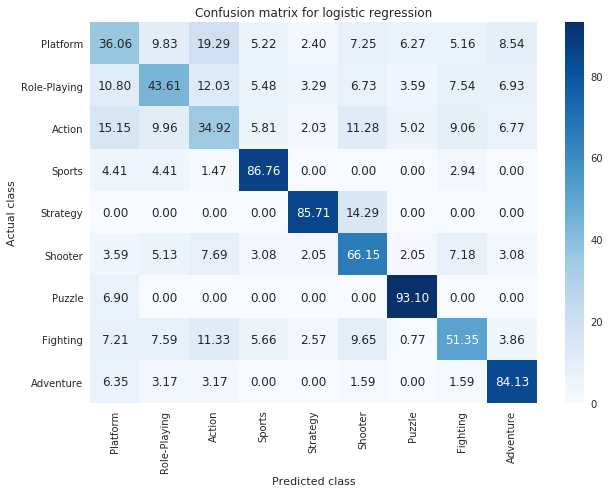

In [250]:
scores_all_1000, features_importances_all_1000, preds_all_1000 = test_with_filters(midis_treshold=1000)

In [272]:
idx, scores = get_most_common_in_top(features_importances_all_1000, 30)
pd.DataFrame(scores, index=columns[idx], columns=['Importance'])

,Importance
Variability_of_Note_Durations,0.010637
Maximum_Note_Duration,0.009854
Average_Note_Duration,0.009690
Average_Time_Between_Attacks_for_Each_Voice,0.009249
Minimum_Note_Duration,0.009189
Average_Number_of_Independent_Voices,0.009181
Mean_Pitch,0.009117
Note_Density,0.009088
Average_Number_of_Simultaneous_Pitches,0.008820
Longest_Complete_Rest,0.008673


6 genres entailing 12406 MIDIs will be considered.
The genres are: Action, Adventure, Fighting, Platform, Role-Playing, Shooter
0.000% of the midis are duplicates


,Platform,Role-Playing,Action,Shooter,Fighting,Adventure
Repartition,0.159117,0.33113,0.221748,0.095921,0.113493,0.078591


Train    Test
accuracy mean  99.97%  48.77%
         std    0.01%   0.88%

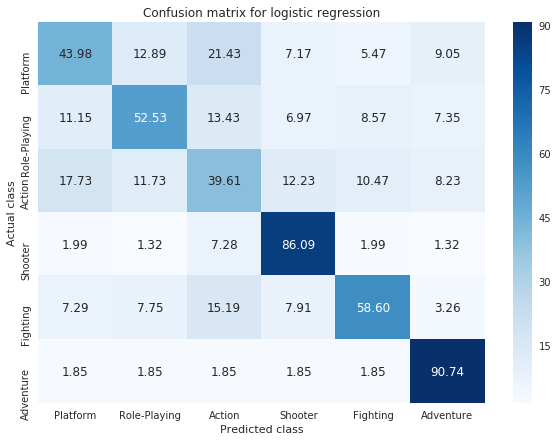

,Importance
Variability_of_Note_Durations,0.011280
Average_Note_Duration,0.010715
Maximum_Note_Duration,0.010314
Average_Time_Between_Attacks_for_Each_Voice,0.010224
String_Ensemble_Prevalence,0.010086
Minimum_Note_Duration,0.009901
Note_Density,0.009803
Variability_of_Time_Between_Attacks,0.009467
Mean_Pitch,0.009402
Average_Variability_of_Time_Between_Attacks_for_Each_Voice,0.009350


In [274]:
scores_all_1500, features_importances_all_1500, preds_all_1500 = test_with_filters(midis_treshold=1500)
idx, scores = get_most_common_in_top(features_importances_all_1500, 30)
pd.DataFrame(scores, index=columns[idx], columns=['Importance'])

In [ ]:
scores_all_2500, features_importances_all_2500, preds_all_2500 = test_with_filters(midis_treshold=2500)
idx, scores = get_most_common_in_top(features_importances_all_2500, 30)
pd.DataFrame(scores, index=columns[idx], columns=['Importance'])

# Interpretation

Both the 9-class and the 6-class Random Forest classification yielded some interesting insights about which musical features are the most distinctive of MIDIs game genre. Notably, 4 of the top 5 features that mattered the most for the classification are related to the note duration. Compiling all graphs related to time dimension in the MIDIs shows truly interesting and consistent results through a selection of few genres. Violinplots below show the distributions of such features according to the game genre. 

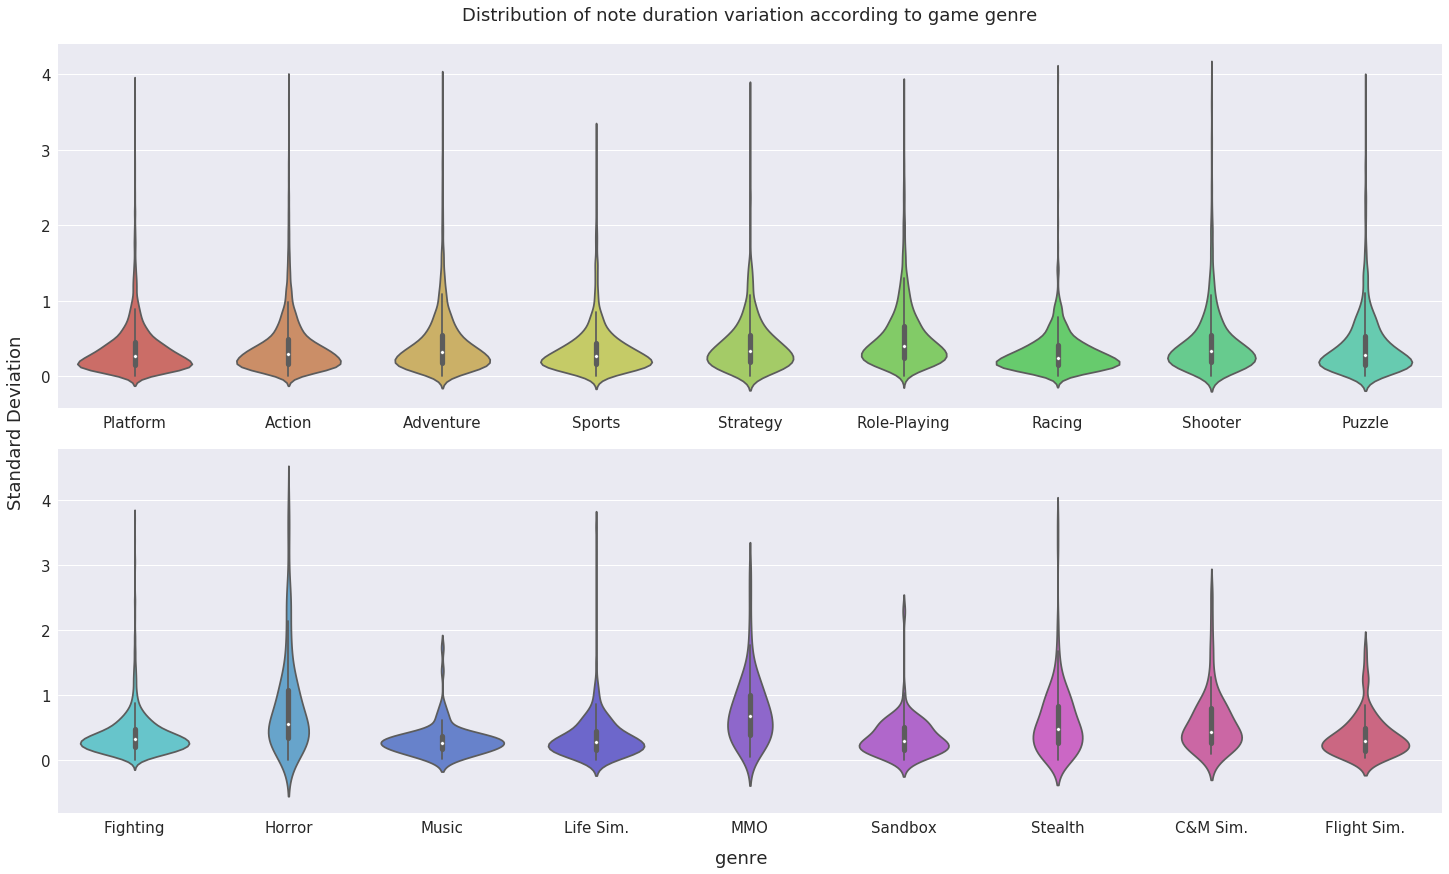

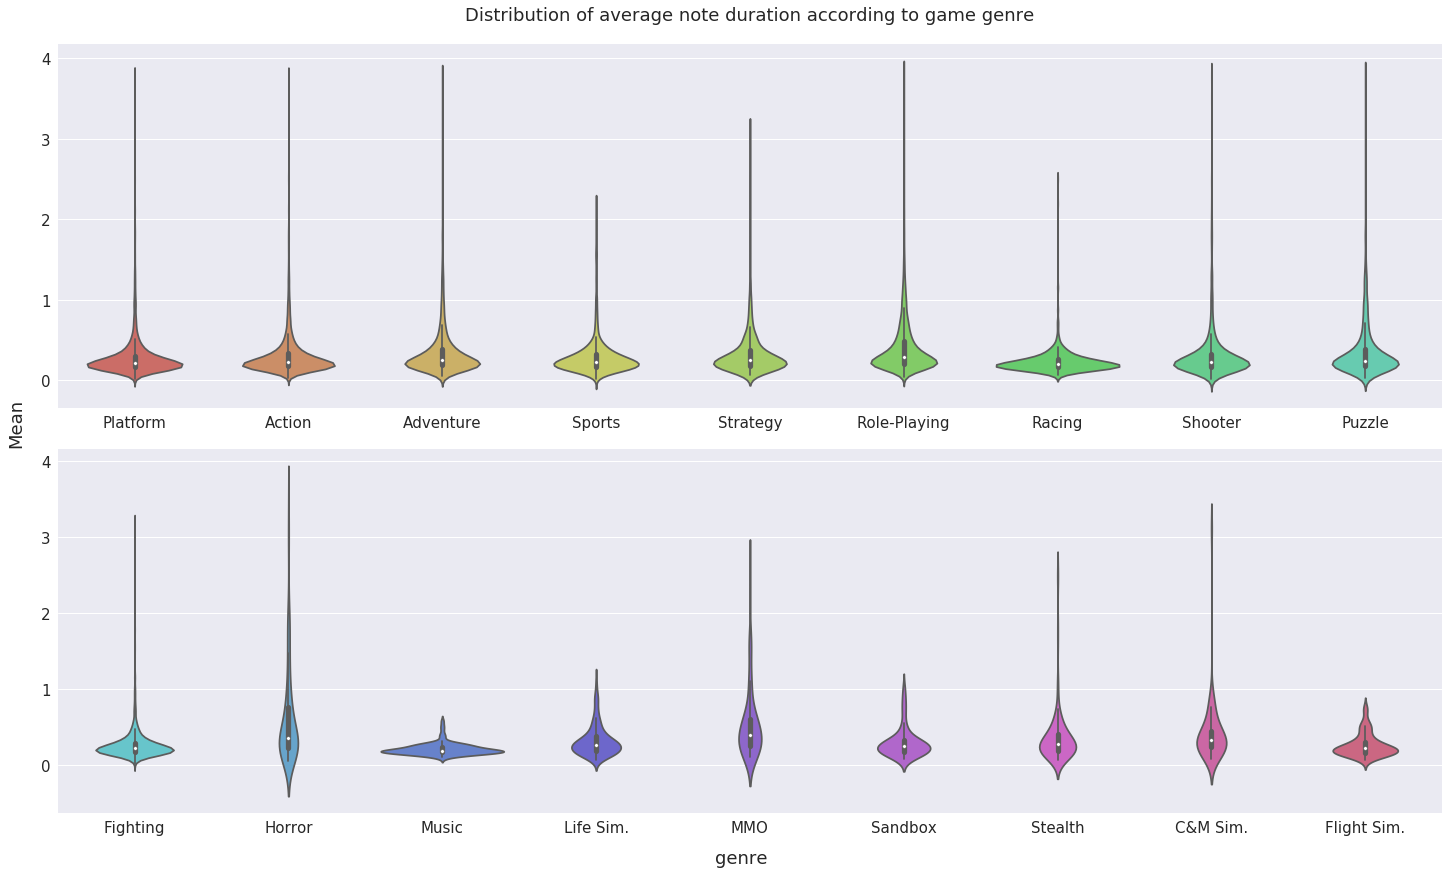

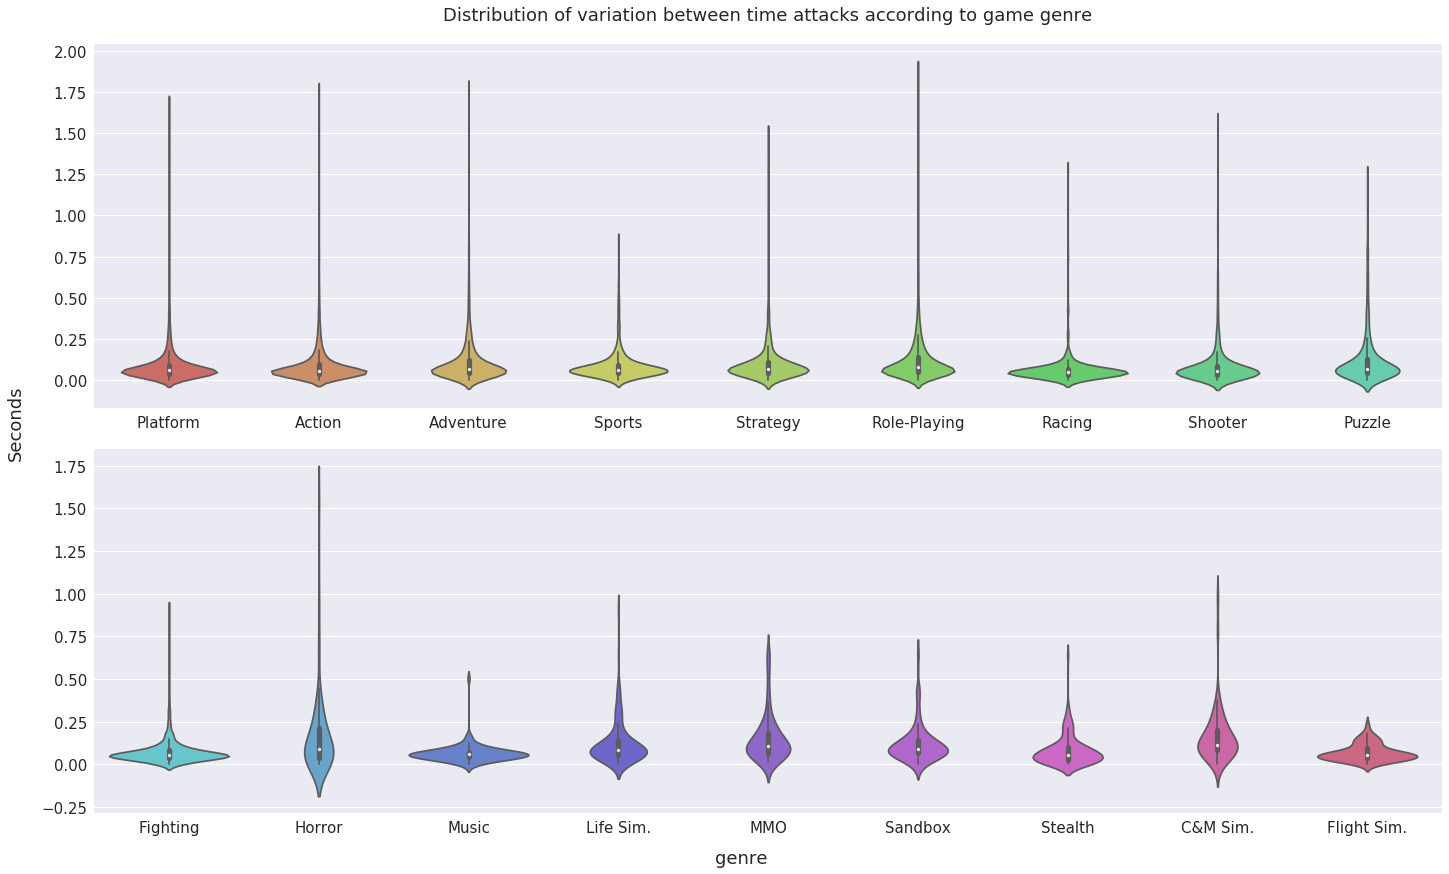

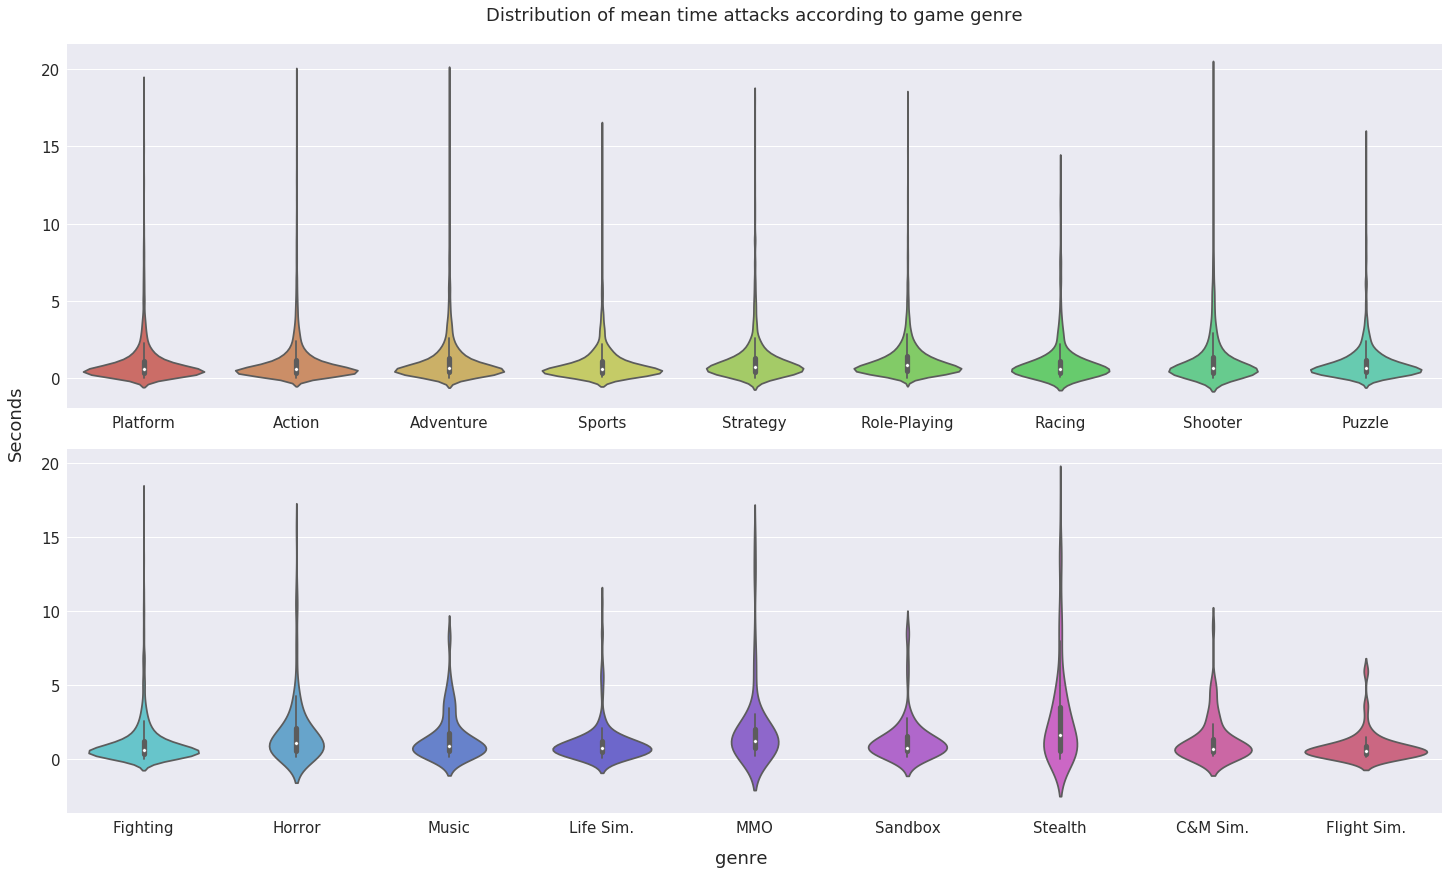

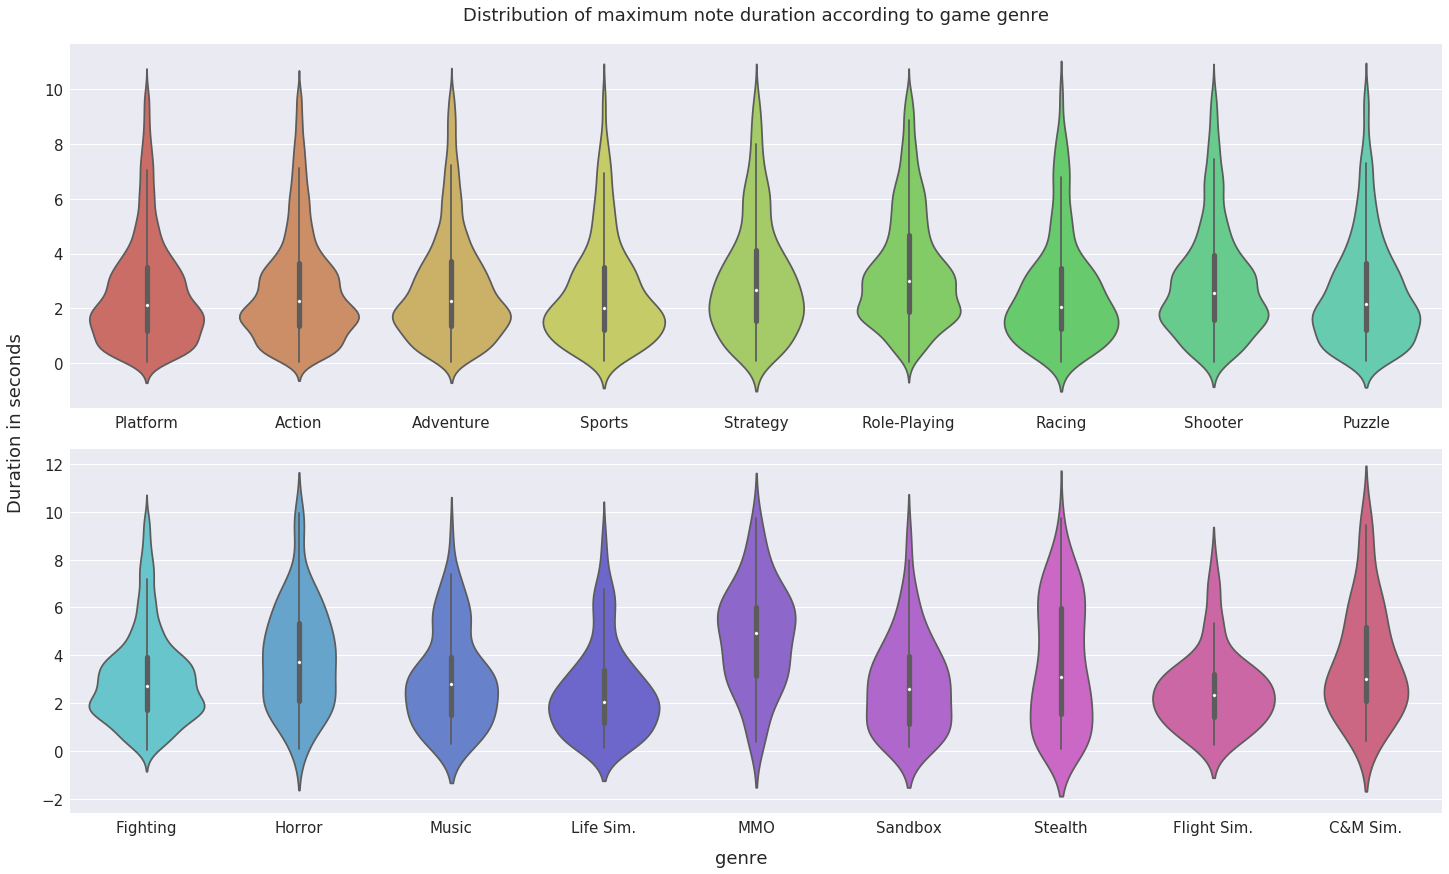

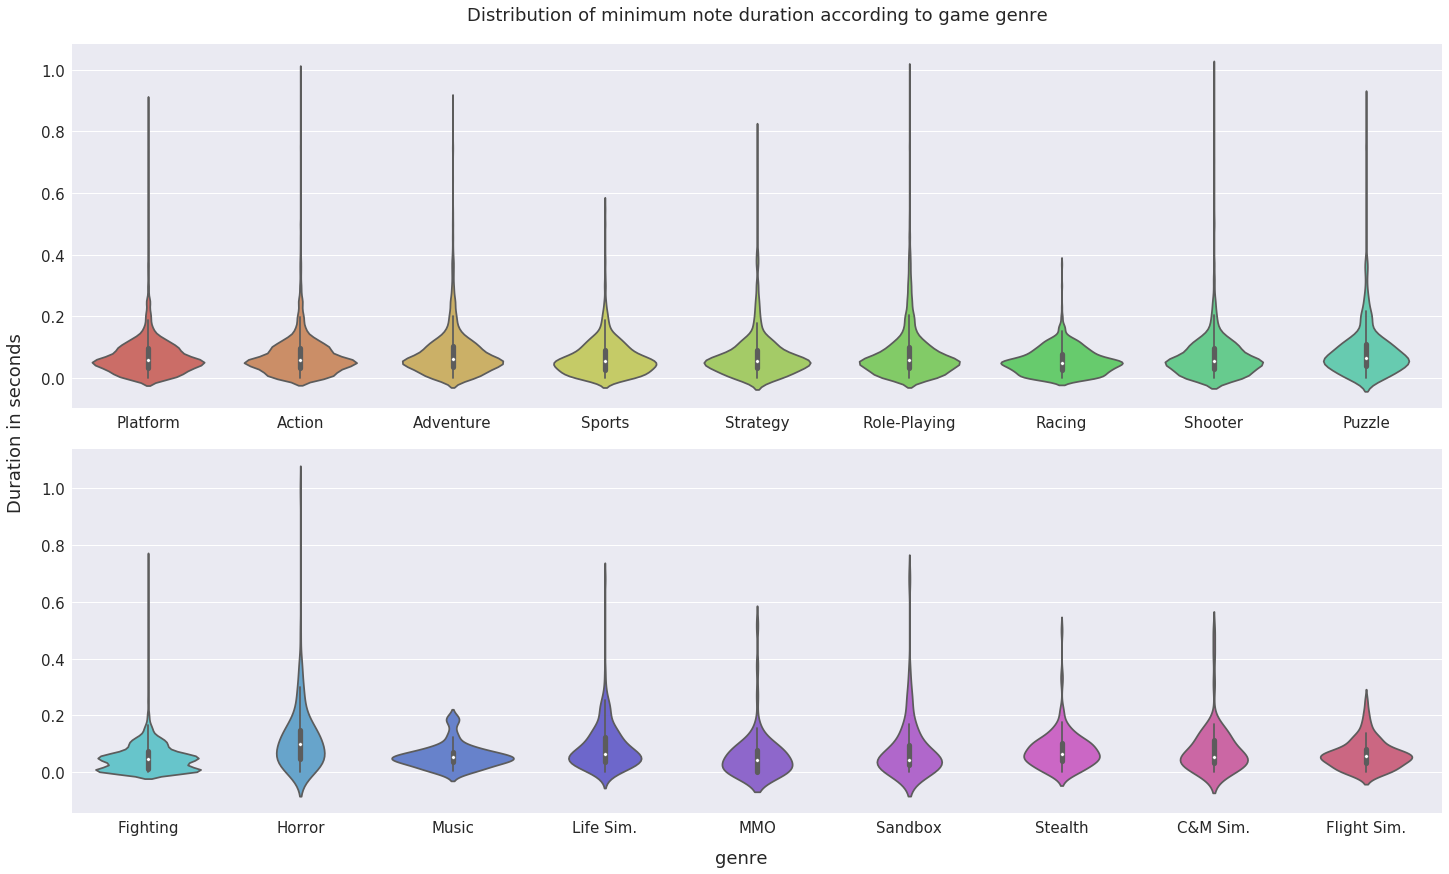

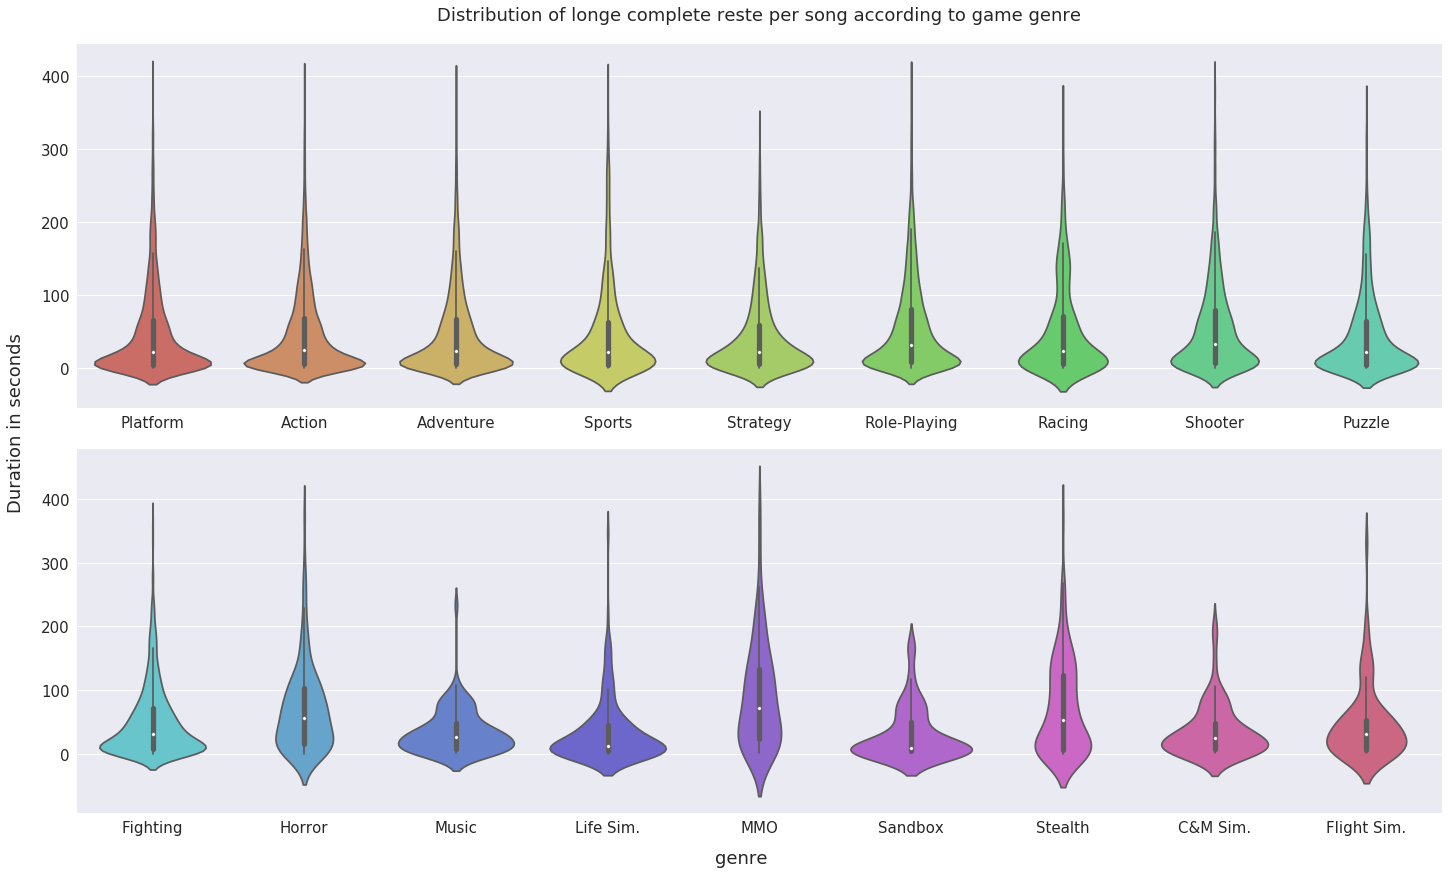

In [75]:
df_pred = df_genres[['genre']].join(df_features, how='inner')
# For more easy displaying of the genre title on the graph
df_pred['genre'] = df_pred['genre'].apply(lambda x : x.replace("Simulator", "Sim.").replace("Simulation", "Sim.").\
             replace("Construction and Management", "C&M"))
df_pred = df_pred[~(df_pred['genre'] == 'Vehicle Sim.')]
#We drop one category, the "Vehicle Simulation" genre, since only one Midi track has this genre.
genres = df_pred['genre'].unique()
palette = sns.color_palette("hls", len(genres))
half = len(genres)//2
def displayViolinWRTGenre(featName, df, title, y_title, threshold = None):
    df_filt = df.copy()
    if threshold:
        df_filt = df_filt[df_filt[featName] < threshold]
        
    sns.set(font_scale = 1.5)
    fig, axes = plt.subplots(2, 1, figsize=(20,12))
    ax = axes[0]
    plt.suptitle('')
    ax.set_title(title+' according to game genre',y=1.05, size=18)
    sns.violinplot(x='genre', y=featName, data=df_filt[df_filt['genre'].isin(genres[:half])], palette=palette[:half],ax=ax)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax = axes[1]
    sns.violinplot(x='genre', y=featName, data=df_filt[df_filt['genre'].isin(genres[half:])], palette=palette[half:], ax=ax)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    fig.text(-0.01, 0.5, y_title, va='center', rotation='vertical', size=18)
    fig.text(0.5, -0.01, 'genre', ha='center', size=18)
    plt.tight_layout()
    plt.show()
    
displayViolinWRTGenre('Variability_of_Note_Durations', df_pred, 'Distribution of note duration variation', 'Standard Deviation', 4)
displayViolinWRTGenre('Average_Note_Duration', df_pred, 'Distribution of average note duration', 'Mean', 4)
displayViolinWRTGenre('Variability_of_Time_Between_Attacks', df_pred, 'Distribution of variation between time attacks', 'Seconds', 2)
displayViolinWRTGenre('Average_Time_Between_Attacks_for_Each_Voice', df_pred, 'Distribution of mean time attacks', 'Seconds', 20)
displayViolinWRTGenre('Maximum_Note_Duration', df_pred, 'Distribution of maximum note duration', 'Duration in seconds', 10)
displayViolinWRTGenre('Minimum_Note_Duration', df_pred, 'Distribution of minimum note duration', 'Duration in seconds', 1)
displayViolinWRTGenre('Longest_Complete_Rest', df_pred, 'Distribution of longe complete reste per song', 'Duration in seconds', 400)

Those data visualisations give very interesting insights about how note durations might characterizes game genre. The genres with the most notable distribution will get analysed and interpretated below :

#### Racing
The distribution of the variability of both note durations for this genre appears to be mostly concentrated in the lower durations, indicating that racing games encounter few note duration changes, and few pauses between two notes through their soundtrack. Thus notes are consistently short, and close to each other in the time dimension. This means MIDIs from such games have melodies of constant fast pace, and few stopping or note left hanging. Such monotonous and interrupted flow of notes goes along very well with the philosophy of racing game where the user needs to be the fastest, i.e. preferably going at a constant fast pace without interruptions. The fast pace seems to be confirmed by the distribution of the maximum duration, whose median for racing game is along the lowest of all the genres and by the minimum duration which is narrowly concentrated cloe to 0 seconds.

This hypothesis seems to applies well to the most classic example of racing game, Mario Kart 8, as the soundtrack consists of mainly jazz-fusion tracks whose instruments are pouring fast-paced licks and wild solos.

#### Music
For average and variability of note durations, the distributions are similar to the one found in racing but even narrower. For the maximum note duration, the distribution is more monotonous however, meaning that even though the stream of note is likely monotonous, the space between notes varies more. Some previous close analysis of what games consist of the "Music" game genre (more commonly called "Rhytmic") shows that most of the MIDIs stems from dancing simulator games. In the case of dance having monotonous notes input makes sense, as the player needs to have a regular stimuli to help planning all of his moves. However the variation of maximum duration seems to imply that music from such games have not the same unique pace as in racing games, which again would be fitting, as slower paced songs are available in dance games for novice players.

#### Horror & Stealth
For average and variability of note durations, both stealth and horror distributions are in opposition to both previous genres. The distributions are more disperse and stretched along the y-axis. This means note duration changes a lot in a song, and between songs too. For horror music, this could be interpreted as a way to surprise the player, which would not expect a set of short fast-paced notes after some long atmospheric ambient chords for example. For stealth game, this would probably be more tied to the immersion. Stealth game often features action sequence (although seldomer than in action/fighting games) intertwined between infiltration sequences. The action sequence likely features faster paced tracks than in infiltration sequences, thus immersing the player into adopting two different game play according to the sequence he gets into.

The main differences between those two genre is most visible in the maximum note duration, which is higher on the y-axis for horror games than for stealth games, again fitting for horror music whose game play is much slower paced and more orientated toward exploration than stealth games.

#### MMO
Massively Multiplayer Online games have a similar distribution for both variability and average duration than both previous genre, but it differs mostly with the maximum note distribution which is the highest of all game genre on the y axis. Which means that most songs will have at least one note that has a unusually long duration compared to all other genres. This point combined with the fact that a previous analysis showed MMO games had the most long songs duration in average, seems to go along with the longevity of MMO games. They are conceived in a way such that player would need tremendous amount of time to complete the game or eventually get bored of it (such decision stem from the monthly subscription paying scheme, the more the user has to do in a game, the longer he will play). Having longer compositions would maybe encourage player to adopt a more slow-paced game play, thus prolonging their playthrough as much as possible.

#### Construction And Management Simulation
TODO (But basically kind of the same as 3 previous genres, except more irregular pauses in between the note apparently) 

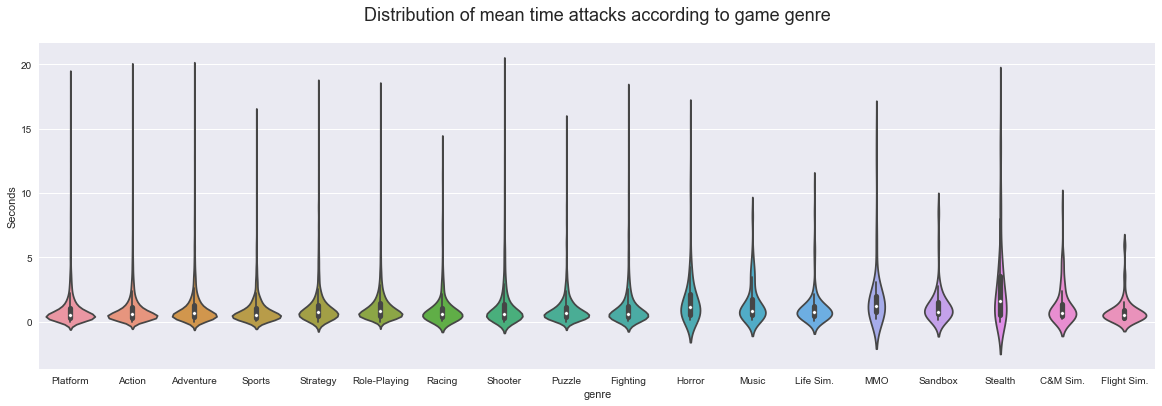

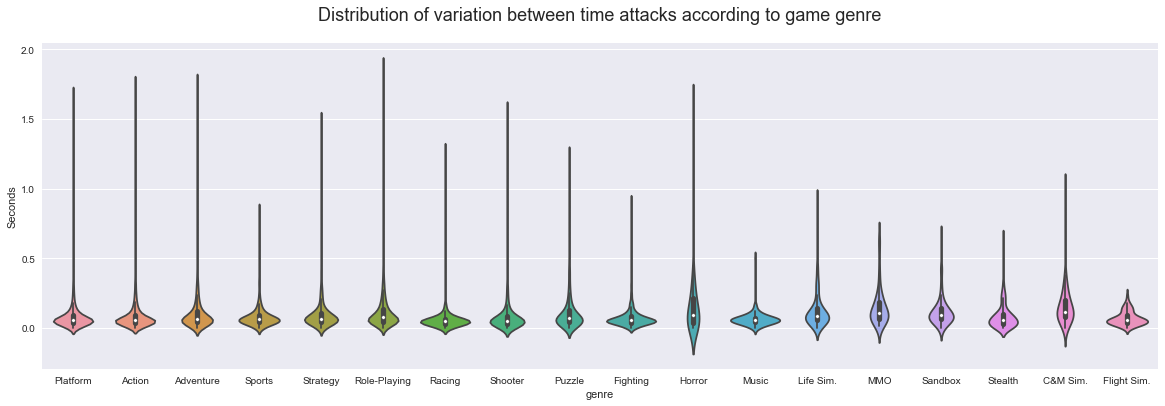

### Pairwise classification
Parwise for all genres which represents at least 3% of the midis.

Without the duplicates, meaning that we drop games that are combination of the pair, i.e. if we test with the pair "Action" and "Platform", we drop all games that are both.

In [387]:
# Run this cell or the one below, attention, below is computationally intensive
features_importance_tuples = np.load('features_importance_tuples.npy')[()]
scores_tuples = np.load('scores_tuples.npy')[()]
preds_tuples = np.load('preds_tuples.npy')[()]
actual_tuples = np.load('actual_tuples.npy')[()]
labels_tuples = np.load('labels_tuples.npy')[()]

2 genres entailing 8232 MIDIs will be considered.
The genres are: Action, Platform
0.000% of the midis are duplicates


,Platform,Action
Repartition,0.290452,0.709548


Train    Test
accuracy mean  99.99%  72.84%
         std    0.01%   0.45%

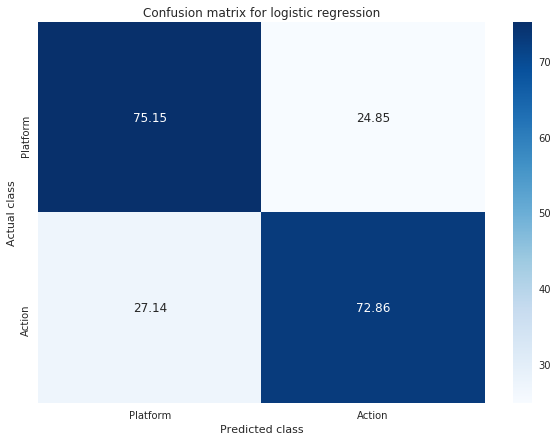

2 genres entailing 8864 MIDIs will be considered.
The genres are: Action, Shooter
0.000% of the midis are duplicates


,Action,Shooter
Repartition,0.849842,0.150158


Train    Test
accuracy mean  99.98%  85.59%
         std    0.01%   0.17%

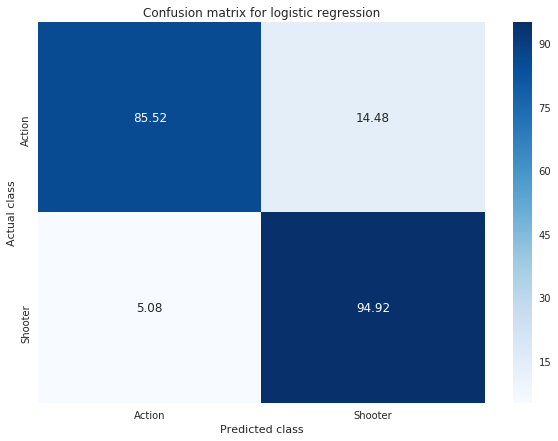

2 genres entailing 11495 MIDIs will be considered.
The genres are: Action, Role-Playing
0.000% of the midis are duplicates


,Action,Role-Playing
Repartition,0.582427,0.417573


Train    Test
accuracy mean  100.00%  73.51%
         std     0.00%   0.77%

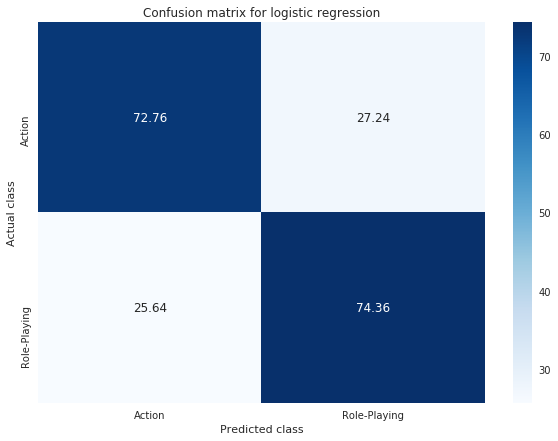

2 genres entailing 9491 MIDIs will be considered.
The genres are: Action, Fighting
0.000% of the midis are duplicates


,Action,Fighting
Repartition,0.847434,0.152566


Train    Test
accuracy mean  99.98%  86.09%
         std    0.01%   0.24%

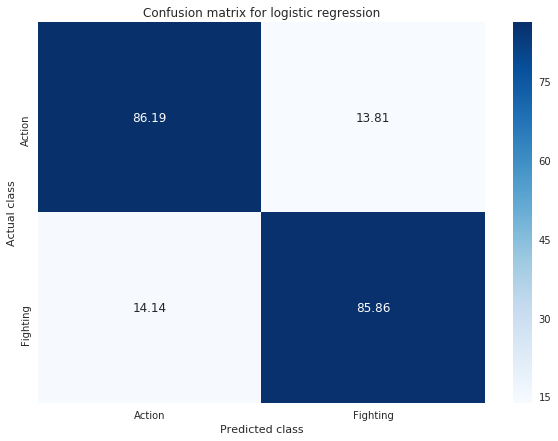

2 genres entailing 7628 MIDIs will be considered.
The genres are: Action, Adventure
0.000% of the midis are duplicates


,Adventure,Action
Repartition,0.260881,0.739119


Train    Test
accuracy mean  99.99%  75.78%
         std    0.01%   0.49%

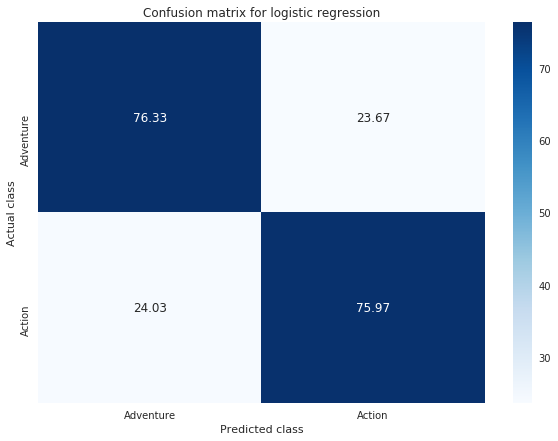

2 genres entailing 8638 MIDIs will be considered.
The genres are: Action, Puzzle
0.000% of the midis are duplicates


,Action,Puzzle
Repartition,0.902871,0.097129


Train    Test
accuracy mean  100.00%  90.52%
         std     0.01%   0.09%

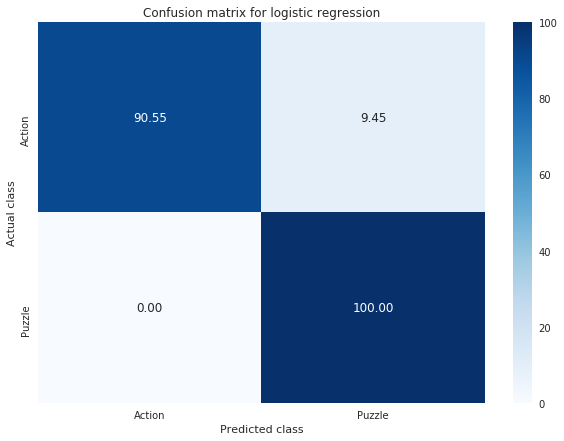

2 genres entailing 9056 MIDIs will be considered.
The genres are: Action, Racing
0.000% of the midis are duplicates


,Action,Racing
Repartition,0.921157,0.078843


Train    Test
accuracy mean  99.99%  92.51%
         std    0.01%   0.16%

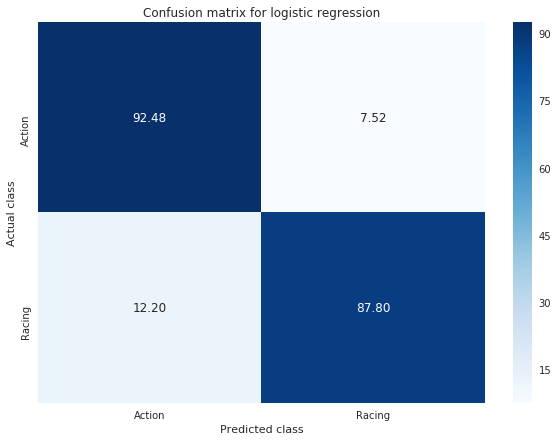

2 genres entailing 9096 MIDIs will be considered.
The genres are: Action, Sports
0.000% of the midis are duplicates


,Action,Sports
Repartition,0.902375,0.097625


Train    Test
accuracy mean  100.00%  90.44%
         std     0.01%   0.11%

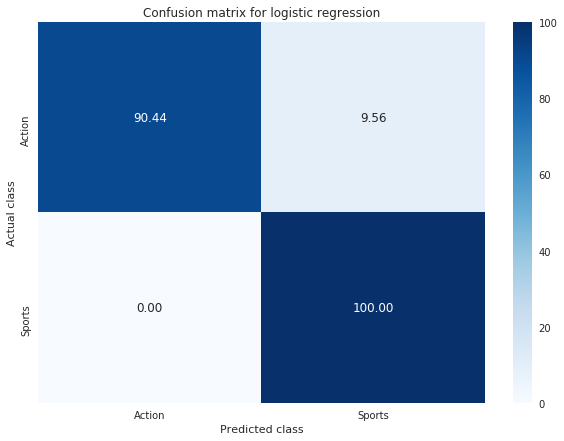

2 genres entailing 9066 MIDIs will be considered.
The genres are: Action, Strategy
0.000% of the midis are duplicates


,Strategy,Action
Repartition,0.09486,0.90514


Train    Test
accuracy mean  99.99%  90.79%
         std    0.01%   0.13%

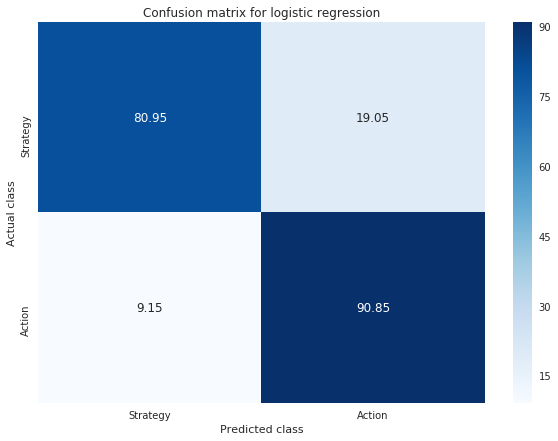

2 genres entailing 6356 MIDIs will be considered.
The genres are: Platform, Shooter
0.000% of the midis are duplicates


,Platform,Shooter
Repartition,0.716488,0.283512


Train    Test
accuracy mean  100.00%  74.63%
         std     0.00%   0.54%

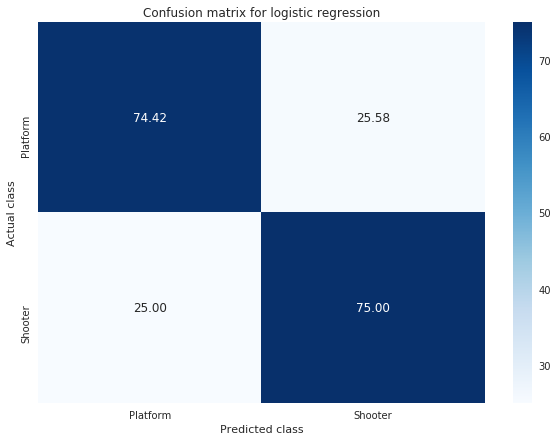

2 genres entailing 10599 MIDIs will be considered.
The genres are: Platform, Role-Playing
0.000% of the midis are duplicates


,Platform,Role-Playing
Repartition,0.426644,0.573356


Train    Test
accuracy mean  100.00%  73.05%
         std     0.00%   0.61%

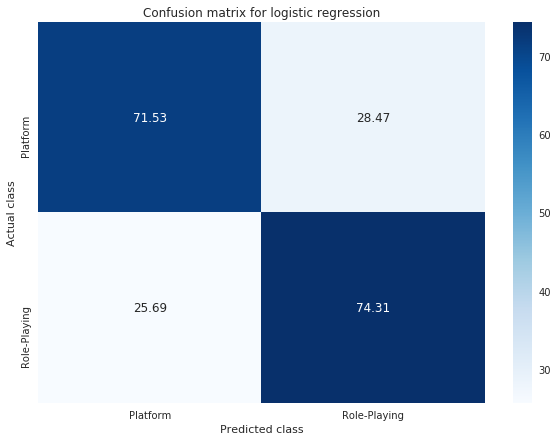

2 genres entailing 6555 MIDIs will be considered.
The genres are: Fighting, Platform
0.000% of the midis are duplicates


,Platform,Fighting
Repartition,0.739893,0.260107


Train    Test
accuracy mean  100.00%  78.78%
         std     0.00%   0.68%

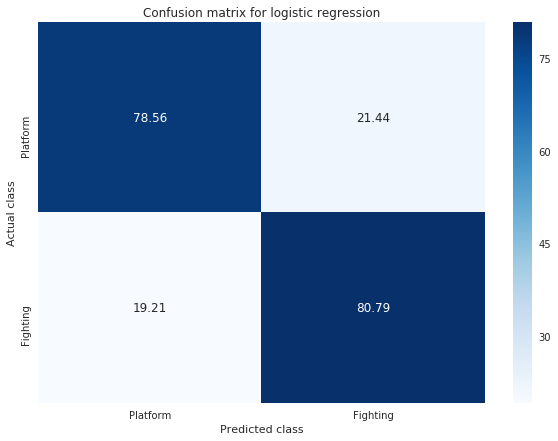

2 genres entailing 6698 MIDIs will be considered.
The genres are: Adventure, Platform
0.000% of the midis are duplicates


,Platform,Adventure
Repartition,0.514781,0.485219


Train    Test
accuracy mean  100.00%  67.93%
         std     0.00%   1.10%

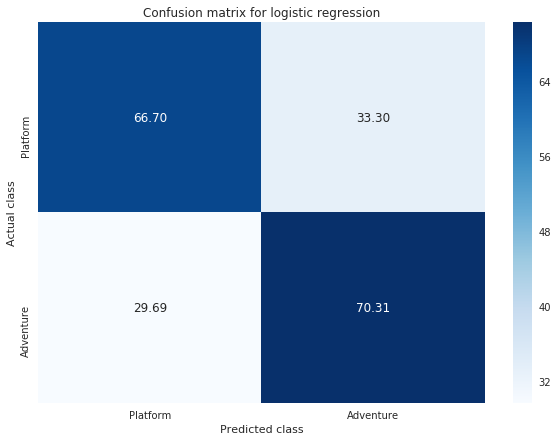

2 genres entailing 5390 MIDIs will be considered.
The genres are: Platform, Puzzle
0.000% of the midis are duplicates


,Platform,Puzzle
Repartition,0.825603,0.174397


Train    Test
accuracy mean  100.00%  83.25%
         std     0.00%   0.25%

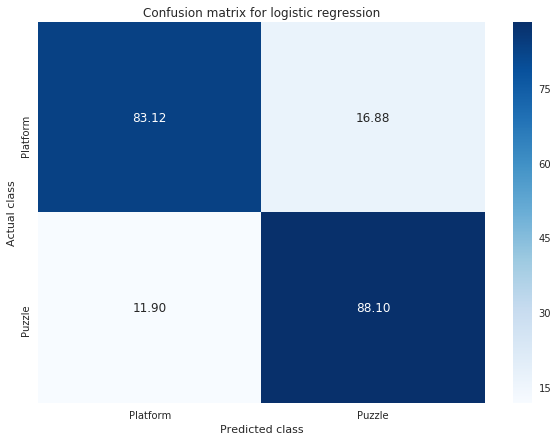

2 genres entailing 5762 MIDIs will be considered.
The genres are: Platform, Racing
0.000% of the midis are duplicates


,Platform,Racing
Repartition,0.862548,0.137452


Train    Test
accuracy mean  100.00%  87.09%
         std     0.00%   0.28%

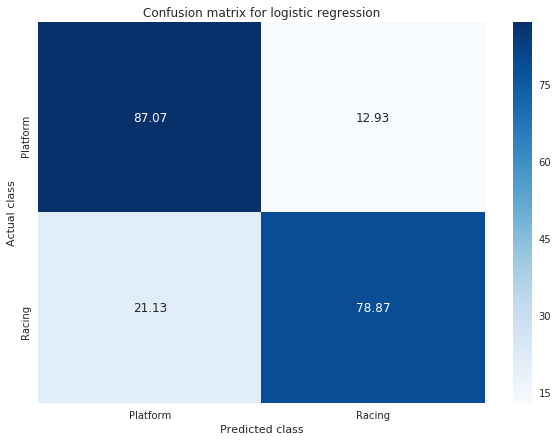

2 genres entailing 5884 MIDIs will be considered.
The genres are: Platform, Sports
0.000% of the midis are duplicates


,Platform,Sports
Repartition,0.828858,0.171142


Train    Test
accuracy mean  100.00%  83.58%
         std     0.00%   0.29%

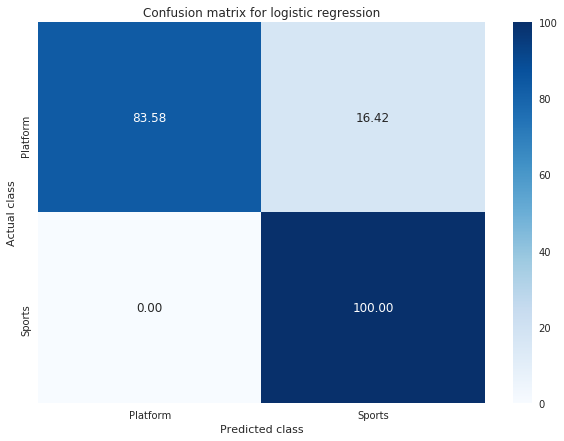

2 genres entailing 6086 MIDIs will be considered.
The genres are: Platform, Strategy
0.000% of the midis are duplicates


,Platform,Strategy
Repartition,0.820079,0.179921


Train    Test
accuracy mean  100.00%  83.28%
         std     0.00%   0.33%

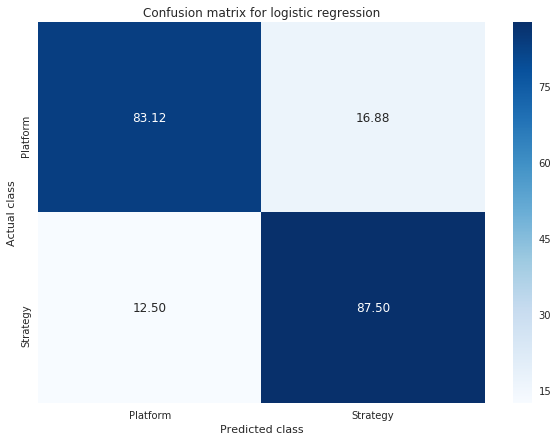

2 genres entailing 8637 MIDIs will be considered.
The genres are: Role-Playing, Shooter
0.000% of the midis are duplicates


,Role-Playing,Shooter
Repartition,0.749334,0.250666


Train    Test
accuracy mean  100.00%  79.04%
         std     0.00%   0.57%

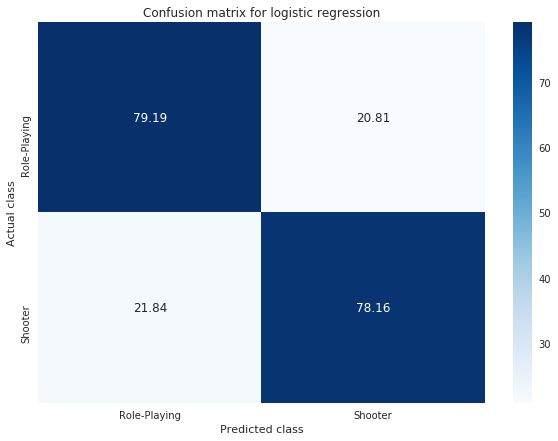

2 genres entailing 4075 MIDIs will be considered.
The genres are: Fighting, Shooter
0.000% of the midis are duplicates


,Shooter,Fighting
Repartition,0.548221,0.451779


Train    Test
accuracy mean  99.98%  70.58%
         std    0.02%   1.56%

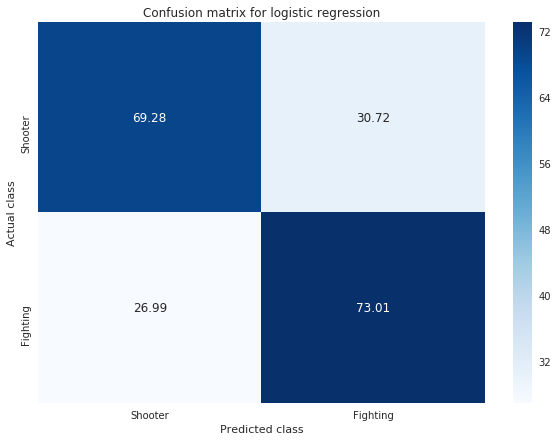

2 genres entailing 6336 MIDIs will be considered.
The genres are: Adventure, Shooter
0.000% of the midis are duplicates


,Adventure,Shooter
Repartition,0.701547,0.298453


Train    Test
accuracy mean  99.97%  75.93%
         std    0.01%   0.90%

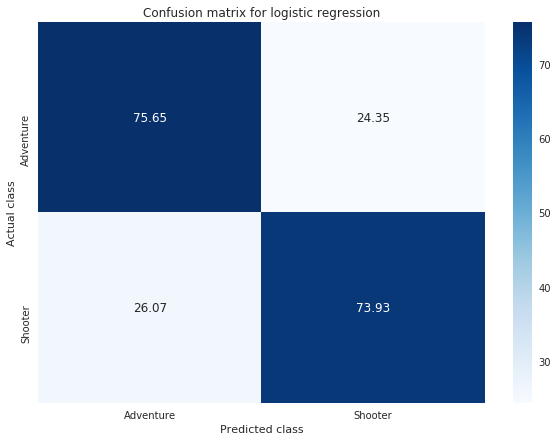

2 genres entailing 3662 MIDIs will be considered.
The genres are: Puzzle, Shooter
0.000% of the midis are duplicates


,Shooter,Puzzle
Repartition,0.603495,0.396505


Train    Test
accuracy mean  100.00%  73.71%
         std     0.00%   1.30%

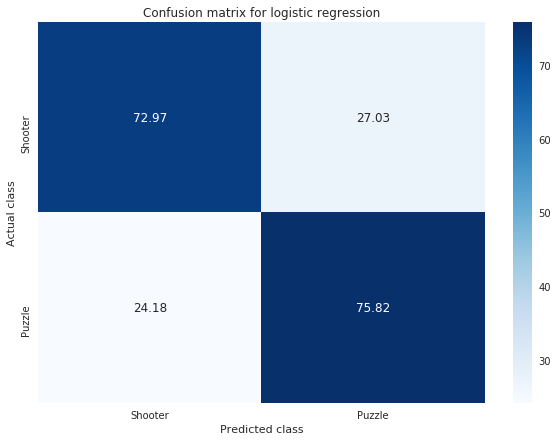

2 genres entailing 3000 MIDIs will be considered.
The genres are: Racing, Shooter
0.000% of the midis are duplicates


,Racing,Shooter
Repartition,0.262333,0.737667


Train    Test
accuracy mean  100.00%  77.40%
         std     0.00%   0.73%

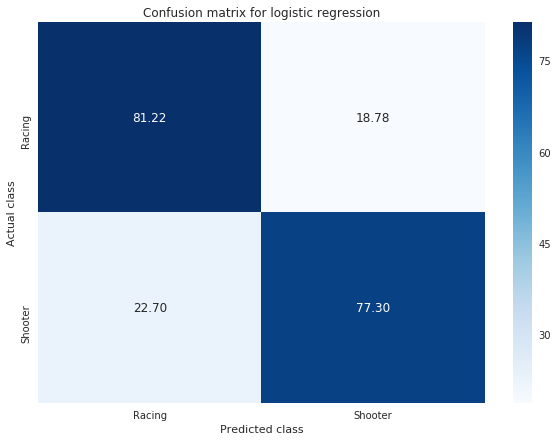

2 genres entailing 3354 MIDIs will be considered.
The genres are: Shooter, Sports
0.000% of the midis are duplicates


,Sports,Shooter
Repartition,0.333333,0.666667


Train    Test
accuracy mean  100.00%  73.49%
         std     0.00%   0.97%

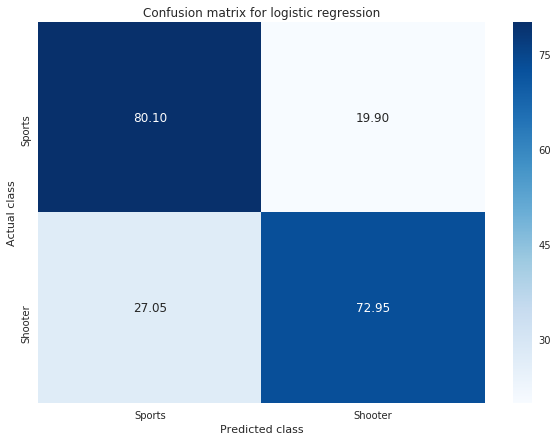

2 genres entailing 3330 MIDIs will be considered.
The genres are: Shooter, Strategy
0.000% of the midis are duplicates


,Strategy,Shooter
Repartition,0.328228,0.671772


Train    Test
accuracy mean  99.98%  75.48%
         std    0.02%   0.97%

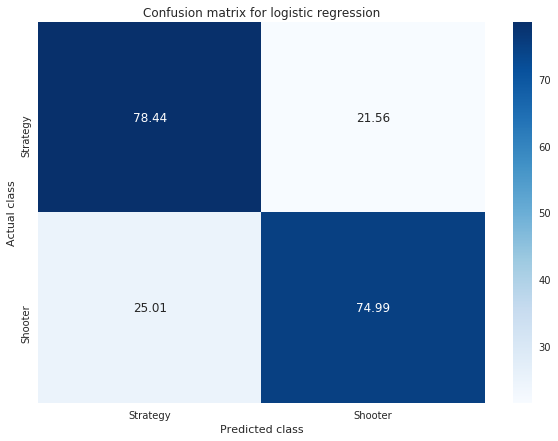

2 genres entailing 8386 MIDIs will be considered.
The genres are: Fighting, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Fighting
Repartition,0.780229,0.219771


Train    Test
accuracy mean  100.00%  82.65%
         std     0.00%   0.55%

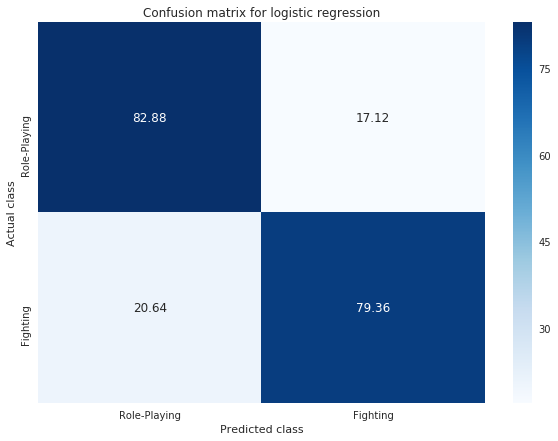

2 genres entailing 8345 MIDIs will be considered.
The genres are: Adventure, Role-Playing
0.000% of the midis are duplicates


,Adventure,Role-Playing
Repartition,0.394967,0.605033


Train    Test
accuracy mean  100.00%  70.73%
         std     0.00%   0.80%

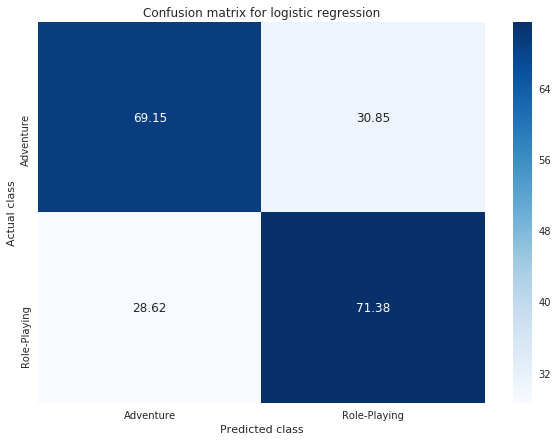

2 genres entailing 6985 MIDIs will be considered.
The genres are: Puzzle, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Puzzle
Repartition,0.862563,0.137437


Train    Test
accuracy mean  100.00%  87.19%
         std     0.01%   0.25%

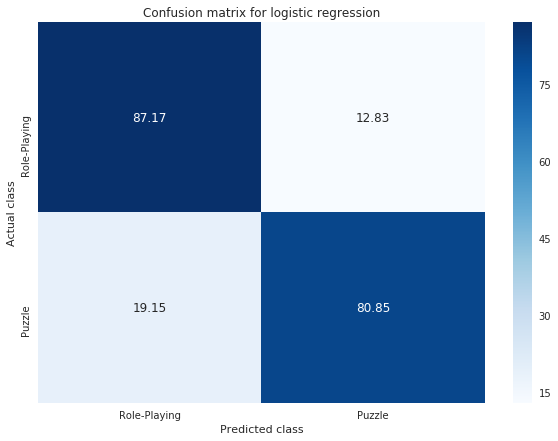

2 genres entailing 7359 MIDIs will be considered.
The genres are: Racing, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Racing
Repartition,0.889523,0.110477


Train    Test
accuracy mean  99.99%  90.19%
         std    0.01%   0.32%

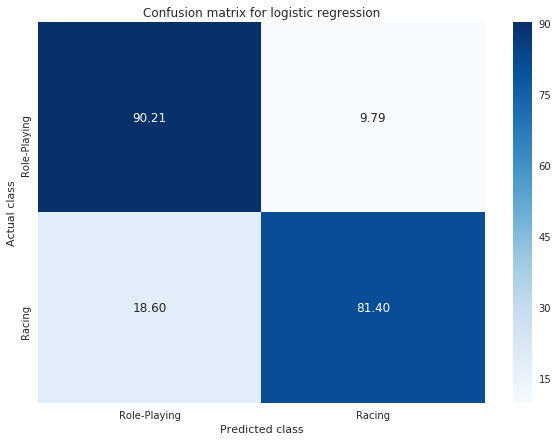

2 genres entailing 7597 MIDIs will be considered.
The genres are: Role-Playing, Sports
0.000% of the midis are duplicates


,Sports,Role-Playing
Repartition,0.142951,0.857049


Train    Test
accuracy mean  100.00%  86.34%
         std     0.00%   0.23%

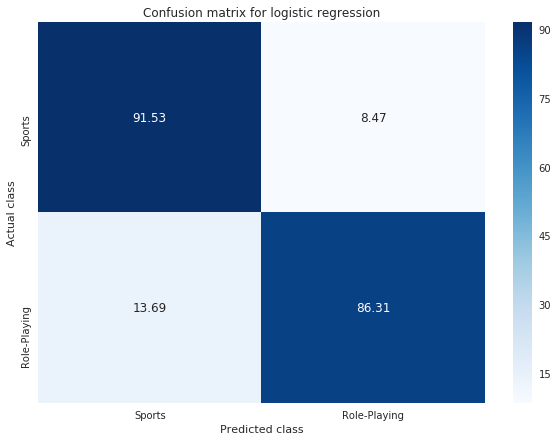

2 genres entailing 6735 MIDIs will be considered.
The genres are: Role-Playing, Strategy
0.000% of the midis are duplicates


,Strategy,Role-Playing
Repartition,0.095323,0.904677


Train    Test
accuracy mean  100.00%  90.65%
         std     0.00%   0.12%

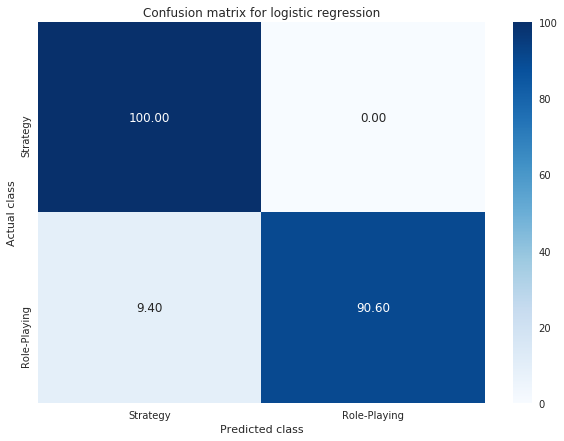

2 genres entailing 6547 MIDIs will be considered.
The genres are: Adventure, Fighting
0.000% of the midis are duplicates


,Adventure,Fighting
Repartition,0.725065,0.274935


Train    Test
accuracy mean  99.99%  79.02%
         std    0.01%   0.78%

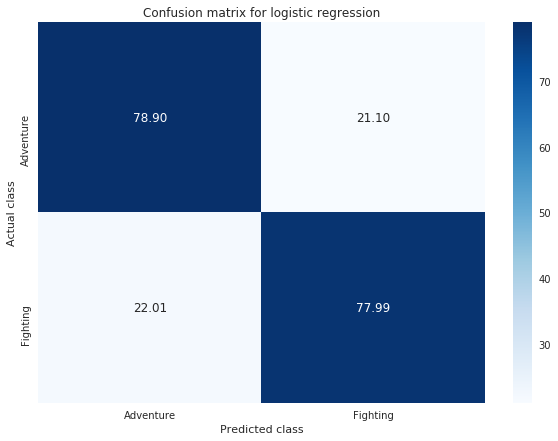

2 genres entailing 3327 MIDIs will be considered.
The genres are: Fighting, Puzzle
0.000% of the midis are duplicates


,Puzzle,Fighting
Repartition,0.445146,0.554854


Train    Test
accuracy mean  99.98%  77.01%
         std    0.02%   1.31%

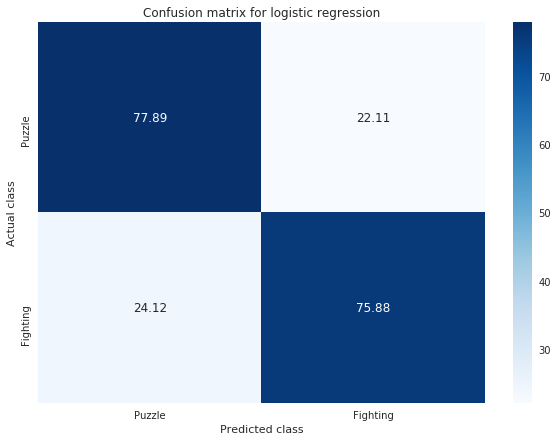

2 genres entailing 2659 MIDIs will be considered.
The genres are: Fighting, Racing
0.000% of the midis are duplicates


,Racing,Fighting
Repartition,0.305754,0.694246


Train    Test
accuracy mean  100.00%  76.13%
         std     0.00%   0.83%

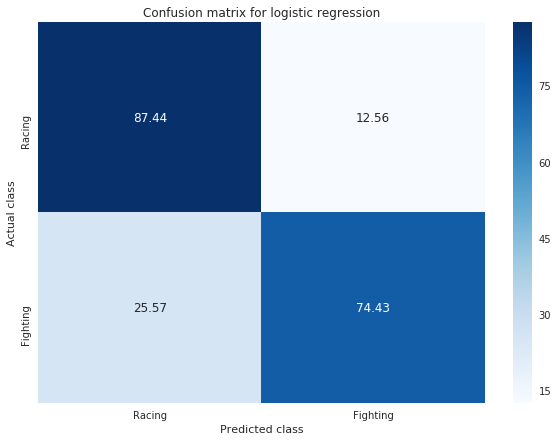

2 genres entailing 2543 MIDIs will be considered.
The genres are: Fighting, Sports
0.000% of the midis are duplicates


,Sports,Fighting
Repartition,0.357452,0.642548


Train    Test
accuracy mean  99.90%  75.71%
         std    0.05%   1.41%

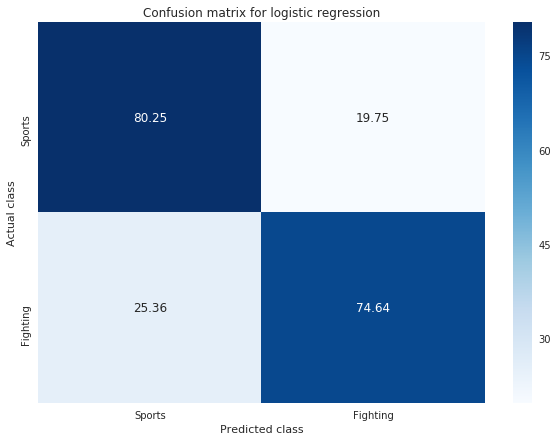

2 genres entailing 2939 MIDIs will be considered.
The genres are: Fighting, Strategy
0.000% of the midis are duplicates


,Strategy,Fighting
Repartition,0.372235,0.627765


Train    Test
accuracy mean  100.00%  76.15%
         std     0.00%   1.67%

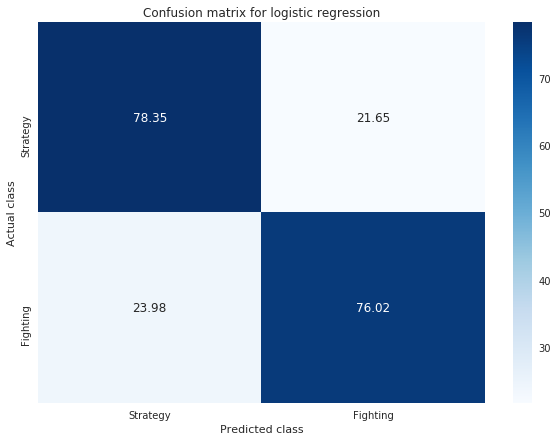

2 genres entailing 5076 MIDIs will be considered.
The genres are: Adventure, Puzzle
0.000% of the midis are duplicates


,Adventure,Puzzle
Repartition,0.826241,0.173759


Train    Test
accuracy mean  100.00%  83.33%
         std     0.00%   0.18%

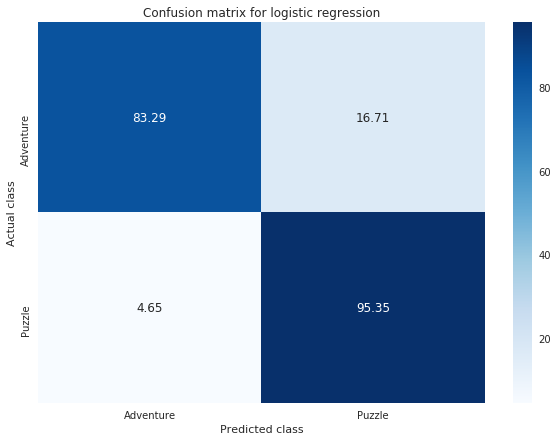

2 genres entailing 5494 MIDIs will be considered.
The genres are: Adventure, Racing
0.000% of the midis are duplicates


,Adventure,Racing
Repartition,0.862213,0.137787


Train    Test
accuracy mean  100.00%  88.05%
         std     0.00%   0.40%

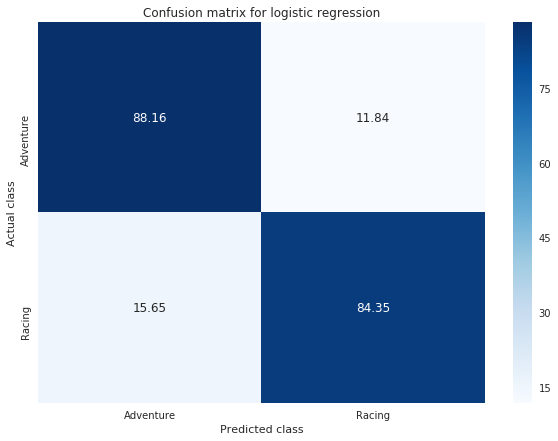

2 genres entailing 5766 MIDIs will be considered.
The genres are: Adventure, Sports
0.000% of the midis are duplicates


,Adventure,Sports
Repartition,0.818418,0.181582


Train    Test
accuracy mean  99.99%  82.89%
         std    0.01%   0.28%

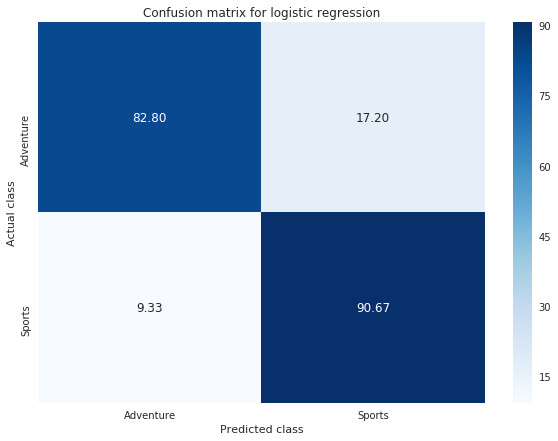

2 genres entailing 5670 MIDIs will be considered.
The genres are: Adventure, Strategy
0.000% of the midis are duplicates


,Adventure,Strategy
Repartition,0.826102,0.173898


Train    Test
accuracy mean  99.99%  83.40%
         std    0.01%   0.23%

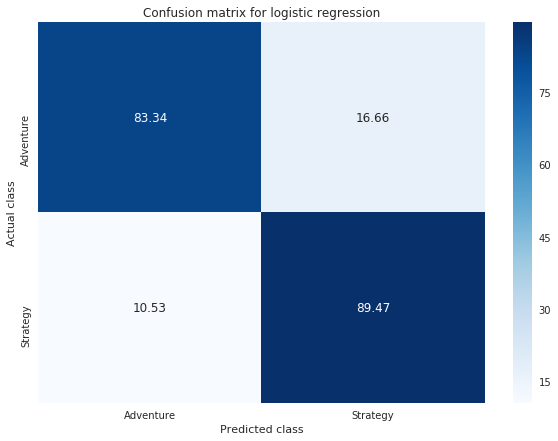

2 genres entailing 2256 MIDIs will be considered.
The genres are: Puzzle, Racing
0.000% of the midis are duplicates


,Racing,Puzzle
Repartition,0.35195,0.64805


Train    Test
accuracy mean  100.00%  79.98%
         std     0.00%   1.50%

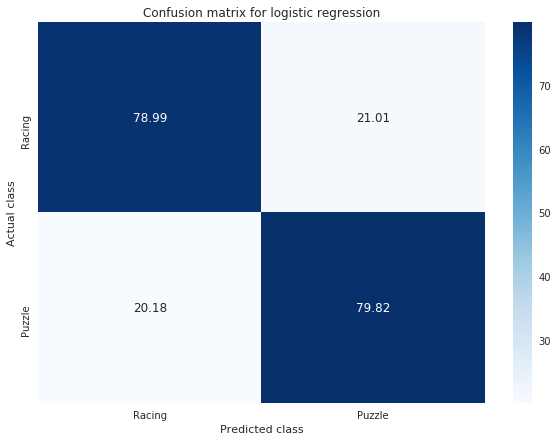

2 genres entailing 2594 MIDIs will be considered.
The genres are: Puzzle, Sports
0.000% of the midis are duplicates


,Sports,Puzzle
Repartition,0.430609,0.569391


Train    Test
accuracy mean  100.00%  70.86%
         std     0.00%   1.70%

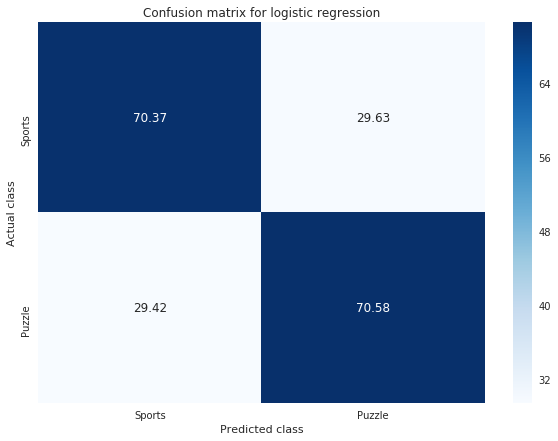

2 genres entailing 2510 MIDIs will be considered.
The genres are: Puzzle, Strategy
0.000% of the midis are duplicates


,Strategy,Puzzle
Repartition,0.423108,0.576892


Train    Test
accuracy mean  100.00%  70.71%
         std     0.00%   1.42%

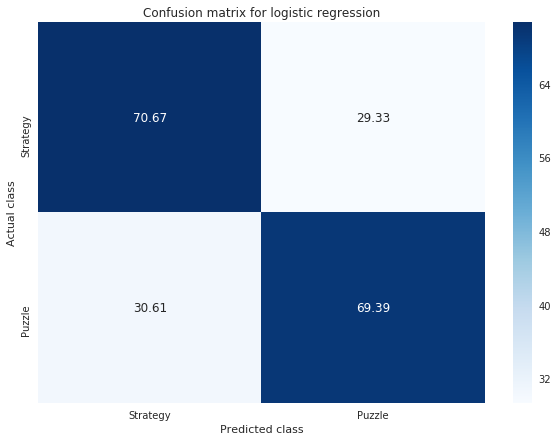

2 genres entailing 1890 MIDIs will be considered.
The genres are: Racing, Sports
0.000% of the midis are duplicates


,Sports,Racing
Repartition,0.581481,0.418519


Train    Test
accuracy mean  100.00%  75.07%
         std     0.00%   2.11%

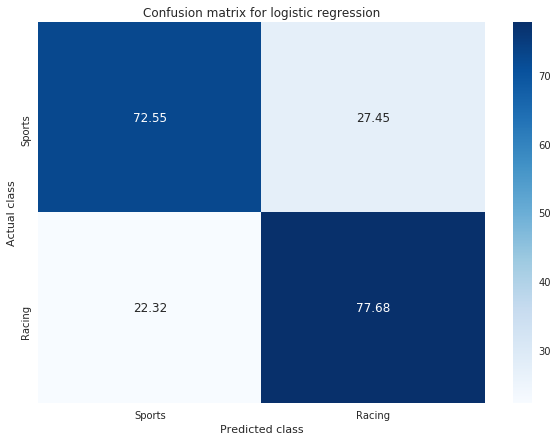

2 genres entailing 1898 MIDIs will be considered.
The genres are: Racing, Strategy
0.000% of the midis are duplicates


,Strategy,Racing
Repartition,0.574289,0.425711


Train    Test
accuracy mean  100.00%  79.17%
         std     0.00%   1.71%

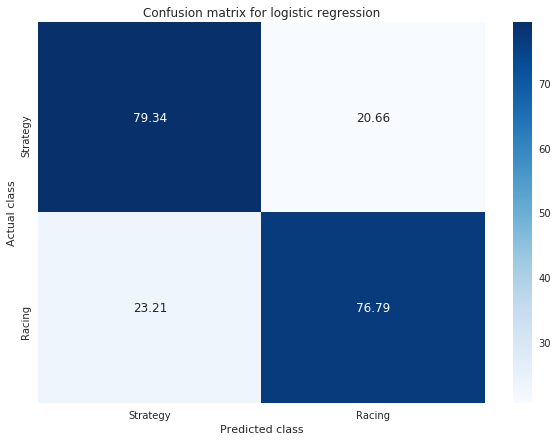

2 genres entailing 2056 MIDIs will be considered.
The genres are: Sports, Strategy
0.000% of the midis are duplicates


,Strategy,Sports
Repartition,0.493677,0.506323


Train    Test
accuracy mean  100.00%  70.84%
         std     0.00%   2.71%

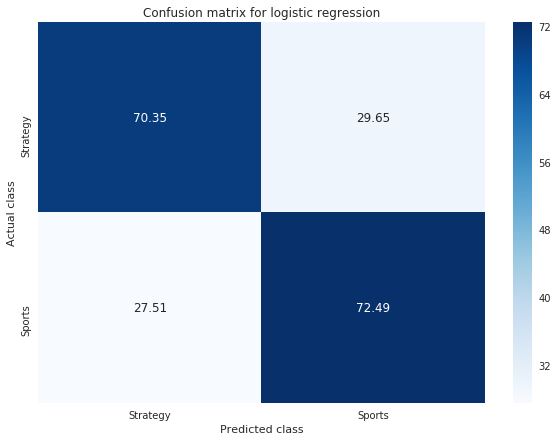

In [277]:
features_importance_tuples = {}
scores_tuples = {}
preds_tuples = {}

selected_genres = ['Action', 'Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Adventure', 'Puzzle', 'Racing', 'Sports', 'Strategy']

for genres in itertools.combinations(selected_genres, 2):
    genres_filter = (df_genres['genre'].isin(genres))
    scores_tuples[genres], features_importance_tuples[genres], preds_tuples[genres] =\
                                        test_with_filters(genres_filter=genres_filter, midis_treshold=0)

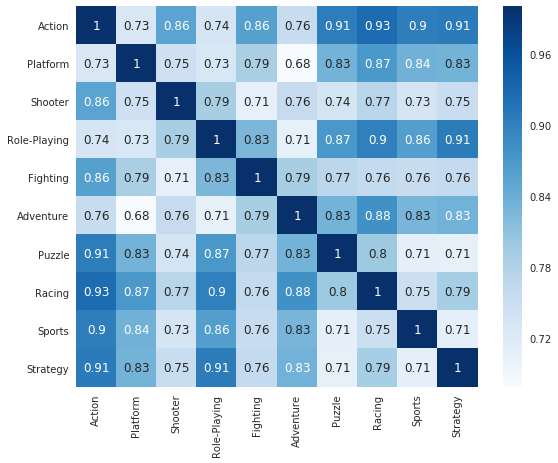

In [392]:
scores_matrix = np.zeros((len(selected_genres), len(selected_genres)))
name2Idx = {v: k for k,v in dict(enumerate(selected_genres)).items()}
for (genre1, genre2), value in scores_tuples.items():
    scores_matrix[name2Idx[genre1], name2Idx[genre2]] = value['test_accuracy'].mean()
scores_matrix += scores_matrix.T
np.fill_diagonal(scores_matrix, 1)

mask = np.zeros_like(scores_matrix)
mask[np.triu_indices_from(mask)] = True
mask = np.zeros_like(scores_matrix)

fig, ax = plt.subplots(figsize=(9,7))
sns.axes_style()
sns.heatmap(scores_matrix, cmap='Blues',annot=True,  mask=mask, xticklabels=name2Idx.keys(), yticklabels=name2Idx.keys(), ax=ax);

In [389]:
for (genre1, genre2), important_features in features_importance_tuples.items():
    print("\033[1m To discriminate between %s and %s \033[0m"%(genre1, genre2))
    idx, scores = get_most_common_in_top(important_features, 25)
    display(pd.DataFrame(scores, index=columns[idx], columns=['Importance']))

 To discriminate between Action and Platform 


,Importance
Variability_of_Note_Durations,0.014184
Average_Note_Duration,0.012100
Maximum_Note_Duration,0.010362
Average_Number_of_Independent_Voices,0.010150
Average_Rest_Fraction_Per_Voice,0.010055
Average_Time_Between_Attacks_for_Each_Voice,0.009807
Chord_Duration,0.009801
Duration,0.009426


 To discriminate between Action and Shooter 


,Importance
Woodwinds_Prevalence,0.013061
Vertical_Sixths,0.012208
Amount_of_Arpeggiation,0.011795
Relative_Note_Durations_of_Lowest_Line,0.011454
Repeated_Notes,0.011392
Electric_Instrument_Prevalence,0.011202
Average_Length_of_Melodic_Arcs,0.010253
Relative_Note_Density_of_Highest_Line,0.010136


 To discriminate between Action and Role-Playing 


,Importance
String_Ensemble_Prevalence,0.023213
Average_Note_Duration,0.016302
Variability_of_Note_Durations,0.016234
Maximum_Note_Duration,0.015236
Strength_of_Strongest_Rhythmic_Pulse,0.013877
Woodwinds_Prevalence,0.013275
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.013233
Average_Time_Between_Attacks_for_Each_Voice,0.012972
Variability_of_Time_Between_Attacks,0.012908
Note_Density,0.011570


 To discriminate between Action and Fighting 


,Importance
Number_of_Unpitched_Instruments,0.020966
Electric_Guitar_Prevalence,0.019521
Minimum_Note_Duration,0.019045
Electric_Instrument_Prevalence,0.018978
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.013651
Chromatic_Motion,0.012740
Mean_Pitch,0.012620
Perfect_Vertical_Intervals,0.012443
Note_Density,0.012396
Vertical_Thirds,0.012306


 To discriminate between Action and Adventure 


,Importance
Note_Density,0.011948
Repeated_Notes,0.011491
Importance_of_Bass_Register,0.010971
Mean_Pitch,0.010227
Average_Number_of_Independent_Voices,0.010061
Strength_of_Strongest_Rhythmic_Pulse,0.009684


 To discriminate between Action and Puzzle 


,Importance
Average_Number_of_Simultaneous_Pitches,0.013794
Variability_of_Number_of_Simultaneous_Pitches,0.013589
Note_Density,0.011331
Relative_Note_Durations_of_Lowest_Line,0.010975
Minor_Major_Triad_Ratio,0.010706
Parallel_Motion,0.010202


 To discriminate between Action and Racing 


,Importance
Electric_Instrument_Prevalence,0.025281
Percussion_Instrument_Prevalence,0.016468
Electric_Guitar_Prevalence,0.015748
Vertical_Tritones,0.015484
Note_Density,0.015417
Diminished_and_Augmented_Triads,0.014820
String_Ensemble_Prevalence,0.014471
Number_of_Unpitched_Instruments,0.013599
Vertical_Minor_Seconds,0.012372
Average_Time_Between_Attacks,0.011978


 To discriminate between Action and Sports 


,Importance
Vertical_Tritones,0.013560
Melodic_Tritones,0.012531
Average_Rest_Fraction_Per_Voice,0.010826
Strongest_Rhythmic_Pulse,0.010730
Minor_Major_Triad_Ratio,0.010105
Relative_Note_Durations_of_Lowest_Line,0.010080


 To discriminate between Action and Strategy 


,Importance
String_Ensemble_Prevalence,0.028956
Strength_of_Second_Strongest_Rhythmic_Pulse,0.013580
Average_Time_Between_Attacks_for_Each_Voice,0.013316
Strength_of_Strongest_Rhythmic_Pulse,0.012890
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.012878
Average_Rest_Fraction_Per_Voice,0.012113
Note_Density,0.011586
Maximum_Note_Duration,0.011256
Average_Variability_of_Time_Between_Attacks_for_Each_Voice,0.010747


 To discriminate between Platform and Shooter 


,Importance
Average_Number_of_Independent_Voices,0.015287
Perfect_Vertical_Intervals,0.014357
Relative_Note_Durations_of_Lowest_Line,0.013661
Melodic_Thirds,0.013218
Variability_of_Note_Durations,0.012412
Prevalence_of_Most_Common_Pitch_Class,0.011959
Repeated_Notes,0.011831
Prevalence_of_Most_Common_Vertical_Interval,0.011617
Amount_of_Arpeggiation,0.011502
Vertical_Sixths,0.011401


 To discriminate between Platform and Role-Playing 


,Importance
String_Ensemble_Prevalence,0.027362
Variability_of_Note_Durations,0.021673
Average_Note_Duration,0.019772
Maximum_Note_Duration,0.017396
Average_Time_Between_Attacks_for_Each_Voice,0.015206
Electric_Instrument_Prevalence,0.013216
Average_Variability_of_Time_Between_Attacks_for_Each_Voice,0.012418
Strength_of_Strongest_Rhythmic_Pulse,0.011739
Note_Density,0.011343
Duration,0.011170


 To discriminate between Platform and Fighting 


,Importance
Number_of_Unpitched_Instruments,0.019788
Minimum_Note_Duration,0.019332
Electric_Guitar_Prevalence,0.018237
Mean_Pitch,0.014677
Perfect_Vertical_Intervals,0.014511
Average_Number_of_Independent_Voices,0.013678
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.013577
Vertical_Thirds,0.013569
Electric_Instrument_Prevalence,0.012883
Repeated_Notes,0.012851


 To discriminate between Platform and Adventure 


,Importance
Electric_Instrument_Prevalence,0.014660
Note_Density,0.014559
Average_Note_Duration,0.013232
Average_Time_Between_Attacks,0.012913
Duration,0.012022
Strength_of_Strongest_Rhythmic_Pulse,0.011394
Average_Time_Between_Attacks_for_Each_Voice,0.011029
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.010834
Relative_Note_Density_of_Highest_Line,0.010172
Variability_of_Time_Between_Attacks,0.009906


 To discriminate between Platform and Puzzle 


,Importance
Pitch_Variety,0.012391
Parallel_Motion,0.011985
Variability_of_Number_of_Simultaneous_Pitches,0.011477
Rhythmic_Variability,0.011399
Average_Time_Between_Attacks,0.010893
Average_Number_of_Simultaneous_Pitches,0.010600


 To discriminate between Platform and Racing 


,Importance
Electric_Instrument_Prevalence,0.022511
Number_of_Unpitched_Instruments,0.019415
Electric_Guitar_Prevalence,0.019337
Percussion_Instrument_Prevalence,0.017423
Vertical_Tritones,0.015090
Vertical_Minor_Seconds,0.014787
Diminished_and_Augmented_Triads,0.014404
Chromatic_Motion,0.014282
Note_Density,0.013710
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.013273


 To discriminate between Platform and Sports 


,Importance
Vertical_Tritones,0.011462
Melodic_Tritones,0.010893


 To discriminate between Platform and Strategy 


,Importance
String_Ensemble_Prevalence,0.025010
Melodic_Thirds,0.011896
Strength_of_Second_Strongest_Rhythmic_Pulse,0.010863
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.010694


 To discriminate between Shooter and Role-Playing 


,Importance
Woodwinds_Prevalence,0.032328
Electric_Instrument_Prevalence,0.019601
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.015970
Strength_of_Strongest_Rhythmic_Pulse,0.014956
Orchestral_Strings_Prevalence,0.014444
Strength_of_Second_Strongest_Rhythmic_Pulse,0.013896
Prevalence_of_Most_Common_Vertical_Interval,0.012909
Mean_Pitch,0.012821
Vertical_Sixths,0.012482
Importance_of_Bass_Register,0.012326


 To discriminate between Shooter and Fighting 


,Importance
Minimum_Note_Duration,0.014224
Number_of_Unpitched_Instruments,0.012970
Electric_Guitar_Prevalence,0.012478
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.012104
Note_Density,0.010762
Duration,0.010706
Variability_of_Note_Durations,0.010678
Relative_Note_Durations_of_Lowest_Line,0.010406
Variability_of_Time_Between_Attacks,0.010322


 To discriminate between Shooter and Adventure 


,Importance
Electric_Instrument_Prevalence,0.022077
Repeated_Notes,0.017312
Vertical_Sixths,0.014158
Strength_of_Strongest_Rhythmic_Pulse,0.014092
Note_Density,0.013820
Woodwinds_Prevalence,0.013710
Average_Number_of_Independent_Voices,0.012834
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.012752
Amount_of_Arpeggiation,0.012182
Strength_of_Second_Strongest_Rhythmic_Pulse,0.012130


 To discriminate between Shooter and Puzzle 


,Importance
Average_Number_of_Independent_Voices,0.018683
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.015358
Relative_Note_Durations_of_Lowest_Line,0.013967
Strength_of_Second_Strongest_Rhythmic_Pulse,0.013791
Strength_of_Strongest_Rhythmic_Pulse,0.013730
Note_Density,0.013250
Woodwinds_Prevalence,0.012944
Repeated_Notes,0.012392
Average_Number_of_Simultaneous_Pitches,0.011727
Importance_of_Bass_Register,0.011435


 To discriminate between Shooter and Racing 


,Importance
String_Ensemble_Prevalence,0.016810
Percussion_Instrument_Prevalence,0.015887
Variability_of_Note_Durations,0.015062
Vertical_Minor_Seconds,0.014085
Electric_Instrument_Prevalence,0.013356
Vertical_Unisons,0.013315
Average_Number_of_Independent_Voices,0.011298
Relative_Note_Durations_of_Lowest_Line,0.010703
Note_Density,0.010535


 To discriminate between Shooter and Sports 


,Importance
Maximum_Note_Duration,0.014415
Variability_of_Note_Durations,0.014231
Variability_of_Time_Between_Attacks,0.012890
Woodwinds_Prevalence,0.012612
Mean_Pitch,0.011160
Voice_Equality_-_Dynamics,0.010405


 To discriminate between Shooter and Strategy 


,Importance
Woodwinds_Prevalence,0.028285
Average_Rest_Fraction_Per_Voice,0.016371
Strength_of_Second_Strongest_Rhythmic_Pulse,0.016297
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.015980
Strength_of_Strongest_Rhythmic_Pulse,0.014647
Variability_of_Time_Between_Attacks,0.011524
Longest_Complete_Rest,0.010496
Electric_Instrument_Prevalence,0.010225


 To discriminate between Role-Playing and Fighting 


,Importance
Electric_Instrument_Prevalence,0.028876
Number_of_Unpitched_Instruments,0.024935
Electric_Guitar_Prevalence,0.022849
Woodwinds_Prevalence,0.021991
Note_Density,0.019839
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.017940
String_Ensemble_Prevalence,0.016083
Percussion_Instrument_Prevalence,0.016031
Strength_of_Strongest_Rhythmic_Pulse,0.015733
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.015145


 To discriminate between Role-Playing and Adventure 


,Importance
String_Ensemble_Prevalence,0.018853
Maximum_Note_Duration,0.017996
Variability_of_Note_Durations,0.016317
Average_Number_of_Simultaneous_Pitches,0.012859
Average_Number_of_Simultaneous_Pitch_Classes,0.011478
Seventh_Chords,0.011222
Average_Time_Between_Attacks_for_Each_Voice,0.010948
Average_Variability_of_Time_Between_Attacks_for_Each_Voice,0.010832
Average_Number_of_Independent_Voices,0.010201
Vertical_Perfect_Fifths,0.010172


 To discriminate between Role-Playing and Puzzle 


,Importance
Variability_of_Note_Durations,0.033060
Maximum_Note_Duration,0.026758
String_Ensemble_Prevalence,0.024281
Average_Number_of_Simultaneous_Pitches,0.018797
Average_Note_Duration,0.016062
Average_Number_of_Simultaneous_Pitch_Classes,0.014516
Non-Standard_Chords,0.013182
Orchestral_Strings_Prevalence,0.011956
Relative_Note_Durations_of_Lowest_Line,0.010551
Average_Number_of_Independent_Voices,0.010515


 To discriminate between Role-Playing and Racing 


,Importance
Electric_Instrument_Prevalence,0.044780
String_Ensemble_Prevalence,0.041269
Strength_of_Strongest_Rhythmic_Pulse,0.024506
Percussion_Instrument_Prevalence,0.023424
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.021262
Woodwinds_Prevalence,0.021188
Note_Density,0.020540
Electric_Guitar_Prevalence,0.019638
Average_Note_Duration,0.019543
Number_of_Relatively_Strong_Rhythmic_Pulses,0.018233


 To discriminate between Role-Playing and Sports 


,Importance
Variability_of_Note_Durations,0.020261
Maximum_Note_Duration,0.018771
String_Ensemble_Prevalence,0.014853
Average_Note_Duration,0.014053
Note_Density,0.013528
Average_Time_Between_Attacks_for_Each_Voice,0.013291
Vertical_Tritones,0.010998
Percussion_Instrument_Prevalence,0.010556
Minor_Major_Triad_Ratio,0.010457


 To discriminate between Role-Playing and Strategy 


,Importance
Variability_of_Note_Durations,0.023008
Maximum_Note_Duration,0.016970
Oblique_Motion,0.016139
Average_Note_Duration,0.015922
String_Ensemble_Prevalence,0.015178
Percussion_Instrument_Prevalence,0.012578
Repeated_Notes,0.012551
Variability_of_Time_Between_Attacks,0.011828


 To discriminate between Fighting and Adventure 


,Importance
Electric_Instrument_Prevalence,0.028543
Electric_Guitar_Prevalence,0.022927
Number_of_Unpitched_Instruments,0.021901
Note_Density,0.020064
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.018995
Repeated_Notes,0.017602
Percussion_Instrument_Prevalence,0.015335
Minimum_Note_Duration,0.013806
Mean_Pitch,0.012427
Average_Number_of_Independent_Voices,0.012150


 To discriminate between Fighting and Puzzle 


,Importance
Number_of_Unpitched_Instruments,0.030748
Electric_Guitar_Prevalence,0.024075
Variability_of_Note_Prevalence_of_Unpitched_Instruments,0.022567
Electric_Instrument_Prevalence,0.019651
Note_Density,0.018970
Average_Number_of_Independent_Voices,0.015946
Mean_Pitch,0.014387
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.014381
Strength_of_Strongest_Rhythmic_Pulse,0.014158
Vertical_Thirds,0.013983


 To discriminate between Fighting and Racing 


,Importance
Variability_of_Note_Durations,0.015618
Maximum_Note_Duration,0.013872
Variability_of_Time_Between_Attacks,0.012494
Minor_Major_Triad_Ratio,0.011550


 To discriminate between Fighting and Sports 


,Importance
Vertical_Thirds,0.016591
Maximum_Note_Duration,0.016134
Minor_Major_Melodic_Third_Ratio,0.014429
Minor_Major_Triad_Ratio,0.014424
Chromatic_Motion,0.014278
Mean_Pitch,0.013927
Variability_of_Note_Durations,0.012689
Contrary_Motion,0.012488
Minimum_Note_Duration,0.011792
Average_Number_of_Simultaneous_Pitches,0.010708


 To discriminate between Fighting and Strategy 


,Importance
Electric_Guitar_Prevalence,0.024348
Woodwinds_Prevalence,0.022368
Electric_Instrument_Prevalence,0.019586
Number_of_Unpitched_Instruments,0.016767
String_Ensemble_Prevalence,0.016763
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.015867
Strength_of_Strongest_Rhythmic_Pulse,0.015461
Strength_of_Second_Strongest_Rhythmic_Pulse,0.014738
Note_Density,0.012729
Mean_Pitch,0.012224


 To discriminate between Adventure and Puzzle 


,Importance
Variability_of_Number_of_Simultaneous_Pitches,0.014334
Variability_of_Note_Durations,0.012989
Average_Number_of_Simultaneous_Pitches,0.012587
Initial_Tempo,0.012092
Melodic_Tritones,0.012009
Variability_of_Voice_Separation,0.011117
Vertical_Tritones,0.011077
Maximum_Note_Duration,0.011019
Relative_Note_Durations_of_Lowest_Line,0.010824
Pitch_Variety,0.010681


 To discriminate between Adventure and Racing 


,Importance
Electric_Instrument_Prevalence,0.038925
Note_Density,0.024872
Percussion_Instrument_Prevalence,0.021924
Electric_Guitar_Prevalence,0.021831
Strength_of_Strongest_Rhythmic_Pulse,0.018193
Average_Time_Between_Attacks,0.016965
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.016920
Diminished_and_Augmented_Triads,0.016551
Number_of_Unpitched_Instruments,0.016173
Vertical_Tritones,0.014641


 To discriminate between Adventure and Sports 


,Importance
Vertical_Tritones,0.015242
Melodic_Tritones,0.014115
Repeated_Notes,0.013269
Note_Density,0.013080
Variation_of_Dynamics,0.009389


 To discriminate between Adventure and Strategy 


,Importance
Repeated_Notes,0.017703
String_Ensemble_Prevalence,0.014524
Average_Number_of_Independent_Voices,0.013879
Melodic_Thirds,0.012605
Melodic_Tritones,0.011627
Average_Rest_Fraction_Per_Voice,0.011572


 To discriminate between Puzzle and Racing 


,Importance
Electric_Instrument_Prevalence,0.030897
Number_of_Unpitched_Instruments,0.027614
Note_Density,0.024432
Strength_of_Strongest_Rhythmic_Pulse,0.023440
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.022930
Electric_Guitar_Prevalence,0.022776
Percussion_Instrument_Prevalence,0.021629
Average_Time_Between_Attacks,0.019673
Strength_of_Second_Strongest_Rhythmic_Pulse,0.019229
Number_of_Relatively_Strong_Rhythmic_Pulses,0.017980


 To discriminate between Puzzle and Sports 


,Importance
Note_Density,0.015092
Number_of_Unpitched_Instruments,0.013811
Average_Number_of_Independent_Voices,0.013240


 To discriminate between Puzzle and Strategy 


,Importance
Repeated_Notes,0.017591
Average_Number_of_Independent_Voices,0.016889
Brass_Prevalence,0.013928
Vertical_Octaves,0.013659
Melodic_Thirds,0.012700
Variability_of_Number_of_Independent_Voices,0.012158
Range,0.011998
Average_Number_of_Simultaneous_Pitches,0.011731


 To discriminate between Racing and Sports 


,Importance
Electric_Instrument_Prevalence,0.018845
Variability_of_Time_Between_Attacks,0.017281
Strength_of_Strongest_Rhythmic_Pulse,0.016817
String_Ensemble_Prevalence,0.015669
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.015192
Strength_of_Second_Strongest_Rhythmic_Pulse,0.014036
Average_Time_Between_Attacks,0.013827
Percussion_Instrument_Prevalence,0.010655


 To discriminate between Racing and Strategy 


,Importance
String_Ensemble_Prevalence,0.040935
Electric_Instrument_Prevalence,0.027289
Woodwinds_Prevalence,0.023683
Combined_Strength_of_Two_Strongest_Rhythmic_Pulses,0.022424
Electric_Guitar_Prevalence,0.021340
Strength_of_Strongest_Rhythmic_Pulse,0.021206
Strength_of_Second_Strongest_Rhythmic_Pulse,0.018617
Note_Density,0.014204
Voice_Equality_-_Number_of_Notes,0.014111
Number_of_Relatively_Strong_Rhythmic_Pulses,0.013434


 To discriminate between Sports and Strategy 


,Importance
String_Ensemble_Prevalence,0.017359
Variability_of_Note_Durations,0.012271
Average_Time_Between_Attacks_for_Each_Voice,0.012121
Maximum_Note_Duration,0.012039
Note_Density,0.011461
Average_Rest_Fraction_Per_Voice,0.011135
Average_Number_of_Independent_Voices,0.010274


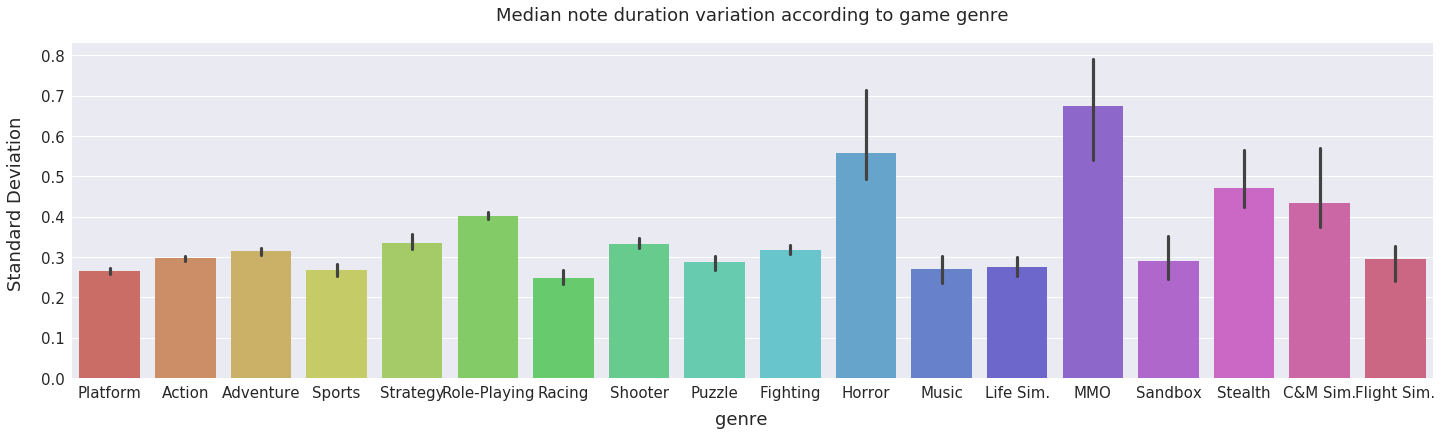

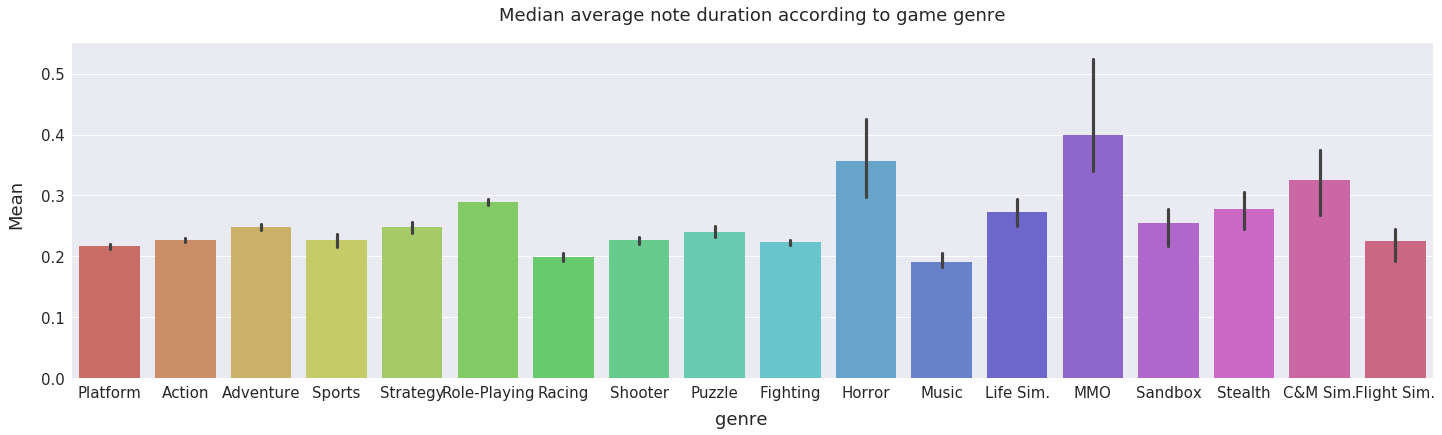

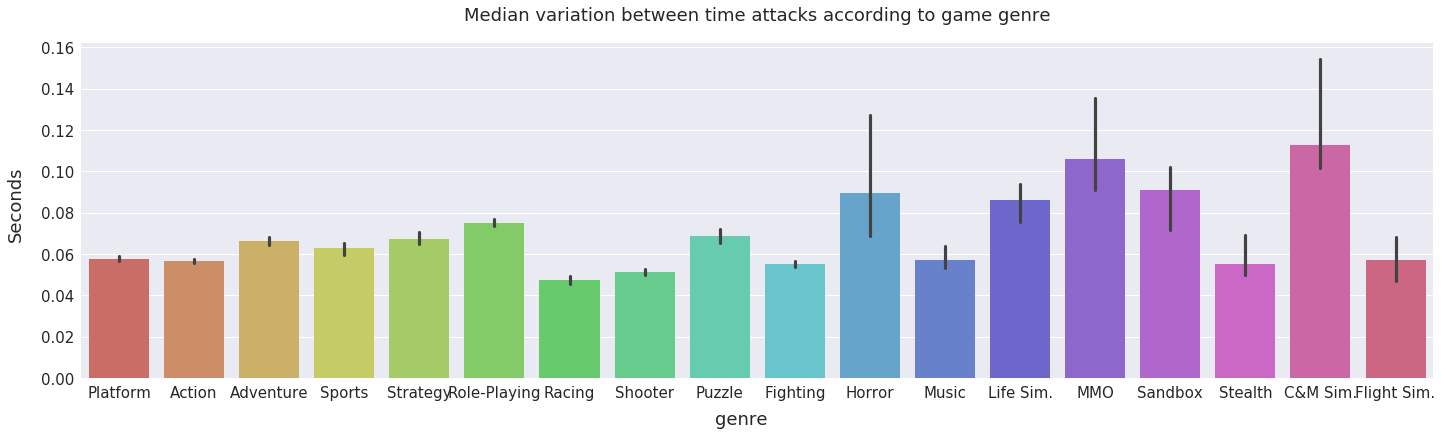

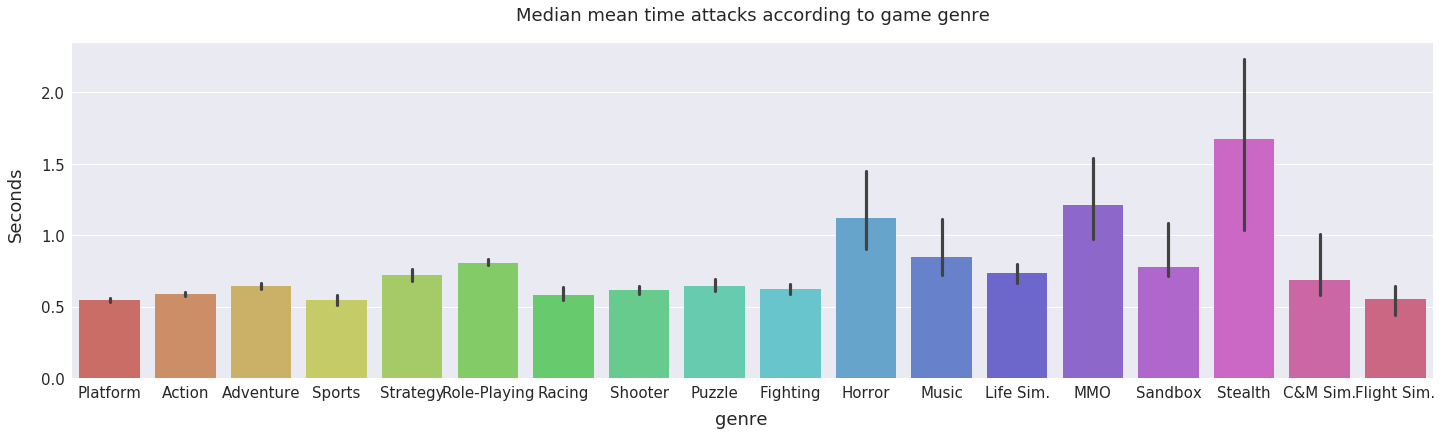

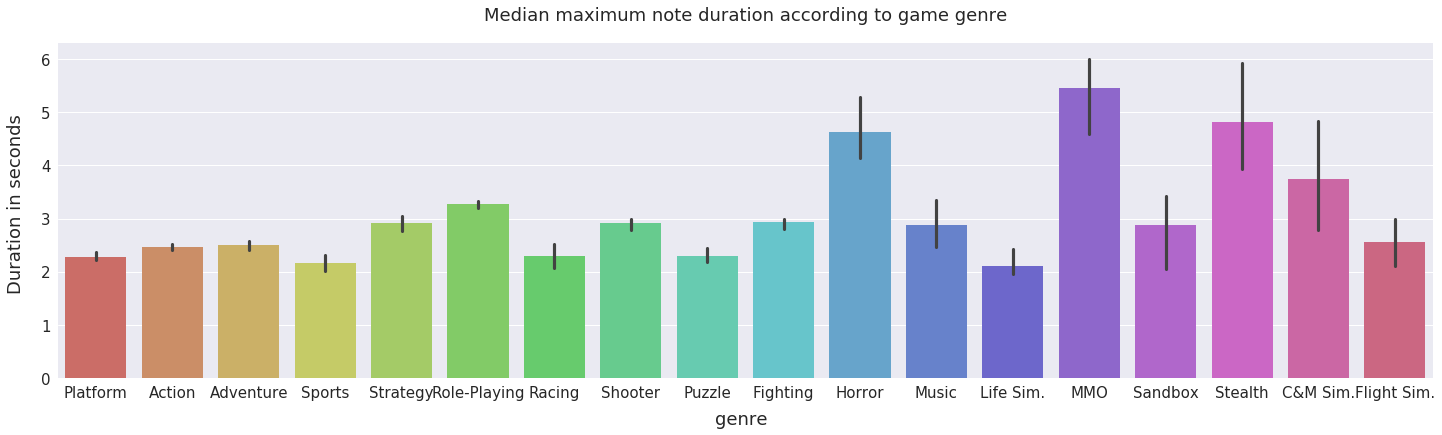

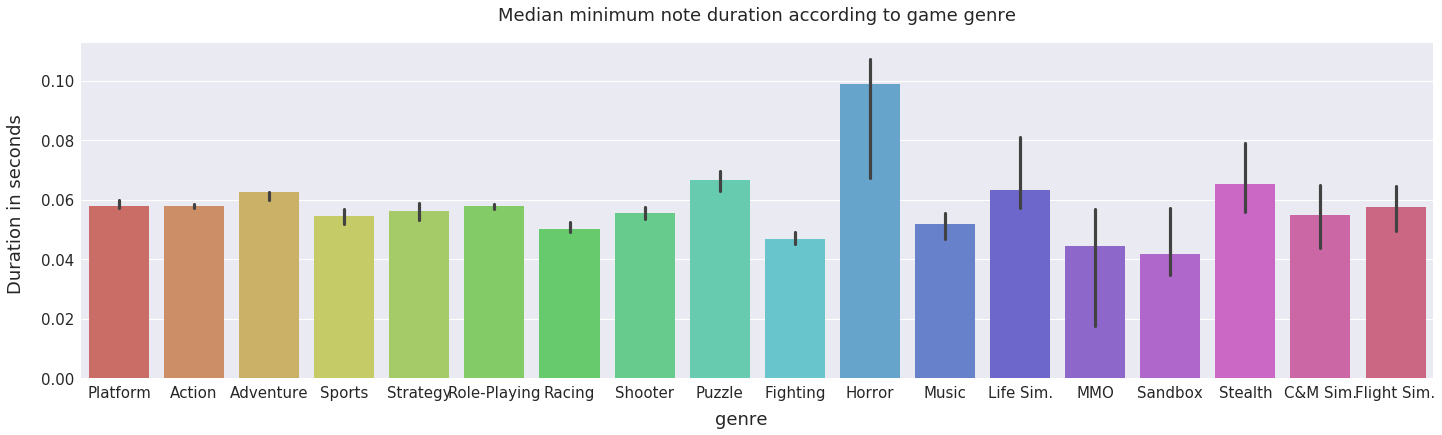

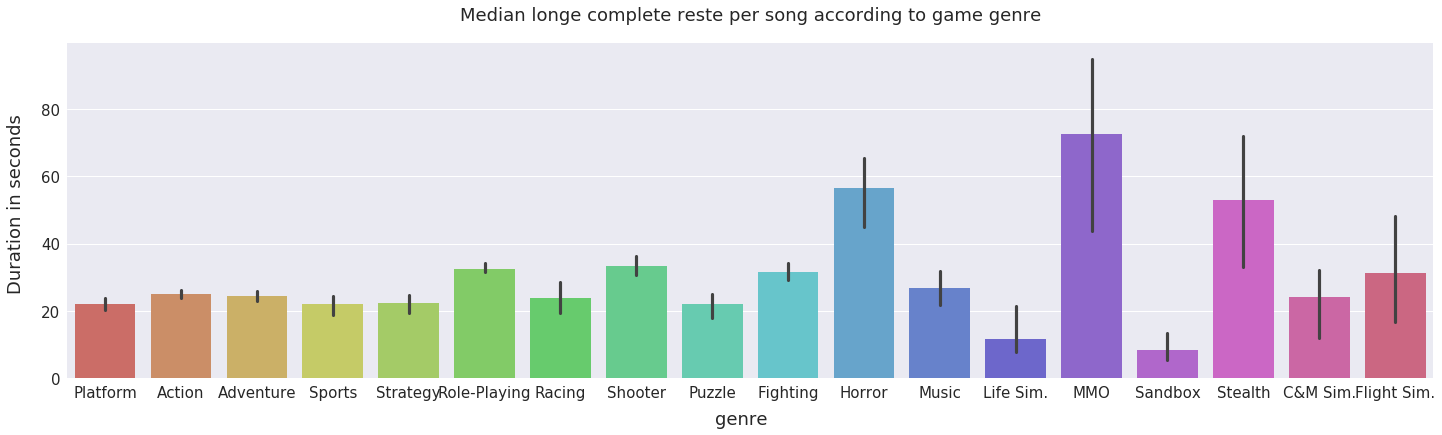

In [84]:
df_pred = df_genres[['genre']].join(df_features, how='inner')
# For more easy displaying of the genre title on the graph
df_pred['genre'] = df_pred['genre'].apply(lambda x : x.replace("Simulator", "Sim.").replace("Simulation", "Sim.").\
             replace("Construction and Management", "C&M"))
df_pred = df_pred[~(df_pred['genre'] == 'Vehicle Sim.')]
#We drop one category, the "Vehicle Simulation" genre, since only one Midi track has this genre.
genres = df_pred['genre'].unique()

def displayMedianBarWRTGenre(featName, df, title, y_title, threshold = None):
    df_filt = df[['genre', featName]].copy()
    if threshold:
        df_filt = df_filt[df_filt[featName] < threshold]
    sns.set(font_scale = 1.5)
    fig, ax = plt.subplots(figsize=(20,6))
    plt.suptitle('')
    ax.set_title(title+' according to game genre',y=1.05, size=18)
    sns.barplot(x='genre', y=featName, data=df_filt, ax=ax, palette=palette, estimator=np.median)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    fig.text(-0.01, 0.5, y_title, va='center', rotation='vertical', size=18)
    fig.text(0.5, -0.01, 'genre', ha='center', size=18)
    plt.tight_layout()
    plt.show()
    
displayMedianBarWRTGenre('Variability_of_Note_Durations', df_pred, 'Median note duration variation', 'Standard Deviation')
displayMedianBarWRTGenre('Average_Note_Duration', df_pred, 'Median average note duration', 'Mean')
displayMedianBarWRTGenre('Variability_of_Time_Between_Attacks', df_pred, 'Median variation between time attacks', 'Seconds')
displayMedianBarWRTGenre('Average_Time_Between_Attacks_for_Each_Voice', df_pred, 'Median mean time attacks', 'Seconds')
displayMedianBarWRTGenre('Maximum_Note_Duration', df_pred, 'Median maximum note duration', 'Duration in seconds')
displayMedianBarWRTGenre('Minimum_Note_Duration', df_pred, 'Median minimum note duration', 'Duration in seconds')
displayMedianBarWRTGenre('Longest_Complete_Rest', df_pred, 'Median longe complete reste per song', 'Duration in seconds')

In [86]:
features = ['Variability_of_Note_Durations',
 'Average_Note_Duration',
 'Variability_of_Time_Between_Attacks',
 'Average_Time_Between_Attacks_for_Each_Voice',
 'Maximum_Note_Duration',
 'Minimum_Note_Duration',
 'Longest_Complete_Rest']
df_pred[['genre']+features].groupby('genre').describe().T

genre                                                   Action    Adventure  \
Average_Note_Duration                       count  8441.000000  4793.000000   
                                            mean      0.368600     0.411639   
                                            std       1.638814     1.515875   
                                            min       0.031650     0.045870   
                                            25%       0.170200     0.181900   
                                            50%       0.227000     0.247400   
                                            75%       0.332600     0.384000   
                                            max     101.800000    66.940000   
Average_Time_Between_Attacks_for_Each_Voice count  8441.000000  4793.000000   
                                            mean      1.136226     1.219210   
                                            std       1.887368     1.906940   
                                            min       0.000000     0.000000   
                                            25%       0.325500     0.366500   
                                            50%       0.585900     0.641800   
                                            75%       1.155000     1.268000   
                                            max      35.750000    29.430000   
Longest_Complete_Rest                       count  8441.000000  4793.000000   
                                            mean     47.871278    47.684063   
                                            std      59.278525    58.950526   
                                            min       0.000000     0.000000   
                                            25%       5.447000     5.873000   
                                            50%      24.870000    24.370000   
                                            75%      68.560000    68.210000   
                                            max     802.600000   576.100000   
Maximum_Note_Duration                       count  8441.000000  4793.000000   
                                            mean      4.832249     4.951241   
                                            std      13.030140    14.859591   
                                            min       0.046300     0.057290   
                                            25%       1.446000     1.455000   
                                            50%       2.474000     2.500000   
                                            75%       4.280000     4.406000   
                                            max     499.000000   611.700000   
Minimum_Note_Duration                       count  8441.000000  4793.000000   
                                            mean      0.078408     0.089227   
                                            std       0.188395     0.241489   
                                            min       0.000000     0.000000   
                                            25%       0.033330     0.036840   
                                            50%       0.057690     0.062500   
                                            75%       0.099210     0.103100   
                                            max      14.000000    14.000000   
Variability_of_Note_Durations               count  8441.000000  4793.000000   
                                            mean      0.511833     0.542680   
                                            std       2.430349     2.077232   
                                            min       0.000000     0.000000   
                                            25%       0.166500     0.174400   
                                            50%       0.297200     0.314400   
                                            75%       0.496400     0.547600   
                                            max     153.100000    73.330000   
Variability_of_Time_Between_Attacks         count  8441.000000  4793.000000   
                                            mean  